<a href="https://colab.research.google.com/github/destaerc/Yverdon_les_tropiques/blob/main/Traitement_Donn%C3%A9es_Decentlab_Meteosuisse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import os
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from pytz import timezone

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# === 1. Chargement des fichiers ===


def load_data(folder_path, file_names):
    dfs = {}
    for key, file_name in file_names.items():
        file_path = os.path.join(folder_path, file_name)
        try:
            dfs[key] = pd.read_csv(file_path, sep=";")
            logging.info(f"{file_name} chargé avec succès.")
        except FileNotFoundError:
            logging.error(f"Fichier introuvable : {file_path}")
            return None
        except Exception as e:
            logging.error(f"Erreur lors du chargement de {file_path} : {e}")
            return None
    return dfs


In [20]:
#Choisir la station à analyser

#Noms stations
#    source : Decentlab
        #'Cimetière',
        #'Jardin de Poche',
        #"Parc d'Entremonts",
        #'Parc des Rives',
        #'Pierre de Savoie',
        #"Place d'Arme",
        #'Place Pestalozzi',
        #'Platane du Château',
        #'Rue de la Plaine'

#   source : HOBO
        #Haldimand
        #Les Isles
        #Hopital
        #Pres du lac
        #ParcST
        #Rue du canal

selected_source = "Decentlab"
selected_station = "Parc des Rives" 

In [21]:
# === 2. Standardisation des colonnes et noms ===
import pandas as pd
import numpy as np

def convert_utc_to_swiss_calendar(dt_series):
    """
    Convertit une série datetime UTC en heure suisse (CET/CEST)
    selon le calendrier des changements d'heure en Europe.
    """
    local_times = []
    for dt in dt_series:
        if pd.isna(dt):
            local_times.append(np.nan)
            continue

        # Calcul des dates de changement d'heure pour l'année courante
        year = dt.year
        # Dernier dimanche de mars
        last_sunday_march = max(pd.date_range(f"{year}-03-01", f"{year}-03-31", freq="D")[pd.date_range(f"{year}-03-01", f"{year}-03-31", freq="D").weekday == 6])
        # Dernier dimanche d'octobre
        last_sunday_oct = max(pd.date_range(f"{year}-10-01", f"{year}-10-31", freq="D")[pd.date_range(f"{year}-10-01", f"{year}-10-31", freq="D").weekday == 6])

        # Application du décalage
        if last_sunday_march <= dt.replace(tzinfo=None) < last_sunday_oct:
            # Heure d'été : UTC+2
            local_times.append(dt + pd.Timedelta(hours=2))
        else:
            # Heure d'hiver : UTC+1
            local_times.append(dt + pd.Timedelta(hours=1))

    return pd.Series(local_times, index=dt_series.index)

def preprocess_data(df1, df2, df3):
    # Dates df1
    df1['datetime'] = pd.to_datetime(df1['heure'], errors='coerce')

    # Conversion MeteoSuisse UTC → Heure suisse basée sur le calendrier
    df2['datetime'] = pd.to_datetime(df2['timestamp'], errors='coerce')
    df2['datetime'] = convert_utc_to_swiss_calendar(df2['datetime'])

    # Sélection et renommage colonnes
    df1_sub = df1[['datetime', 'station', 'temperature', 'humidity']].copy()
    df2_sub = df2[['datetime', 'station_abbr', 'tre200h0', 'rre150h0', 'gre000h0', 'ure200h0', 'fkl010h1']].copy()
    df2_sub.rename(columns={'tre200h0': 'temperature', 'ure200h0': 'humidity'}, inplace=True)

    # Standardisation noms stations Decentlab et Hobo
    mapping = {
        'cimeti re': 'Cimetière',
        'jardin de poche': 'Jardin de Poche',
        'parc d entremonts': "Parc d'Entremonts",
        'parc des rives': 'Parc des Rives',
        'pierre de savoie': 'Pierre de Savoie',
        'place d arme': "Place d'Arme",
        'place pestalozzi': 'Place Pestalozzi',
        'platane du ch teau': 'Platane du Château',
        'rue de la plaine': 'Rue de la Plaine',
    
    }
    df1_sub['station'] = df1_sub['station'].str.lower().str.strip()
    df1_sub['station'] = df1_sub['station'].replace(mapping)

    # Ajouter source
    df1_sub['source'] = 'Decentlab'
    df2_sub['source'] = 'MeteoSuisse'

    # --- TRAITEMENT HOBO ---
    # Harmoniser les noms de colonnes
    if 'heure' in df3.columns:
        df3['datetime'] = pd.to_datetime(df3['heure'], errors='coerce')
    elif 'timestamp' in df3.columns:
        df3['datetime'] = pd.to_datetime(df3['timestamp'], errors='coerce')
    else:
        df3['datetime'] = pd.NaT

    if 'station' not in df3.columns and 'station_name' in df3.columns:
        df3['station'] = df3['station_name']

    df3_sub = df3[['datetime', 'station', 'temperature', 'humidity']].copy()
    df3_sub['source'] = 'HOBO'
    df3_sub['station'] = df3_sub['station'].str.replace('_', ' ').str.strip().str.title()

    # Correction des fautes de nom connues pour HOBO
    df3_sub['station'] = df3_sub['station'].replace({
    'Les Ilses': 'Les Isles'
    })
    # Concaténer les trois sources
    combined = pd.concat([df1_sub, df2_sub, df3_sub], ignore_index=True)

    # Nettoyer
    combined = combined.dropna(subset=['temperature'])
    combined = pd.concat([
        combined[combined['source'] == 'Decentlab'].dropna(subset=['station']),
        combined[combined['source'] == 'MeteoSuisse'].dropna(subset=['station_abbr']),
        combined[combined['source'] == 'HOBO'].dropna(subset=['station'])
    ], ignore_index=True)

    return combined

In [22]:
folder = r'C:\Users\vincent.destaerc\Documents\GitHub\Yverdon_les_tropiques\Export csv'
files = {
    'df1': 'decentlab_moyennes_horaires.csv',
    'df2': 'meteo_suisse_MAH.csv',
    'df3': 'hobo_moyennes_horaires.csv'
}
dfs = load_data(folder, files)

if dfs is not None:
    combined_df = preprocess_data(dfs['df1'], dfs['df2'], dfs['df3'])

INFO: decentlab_moyennes_horaires.csv chargé avec succès.
INFO: meteo_suisse_MAH.csv chargé avec succès.
INFO: hobo_moyennes_horaires.csv chargé avec succès.


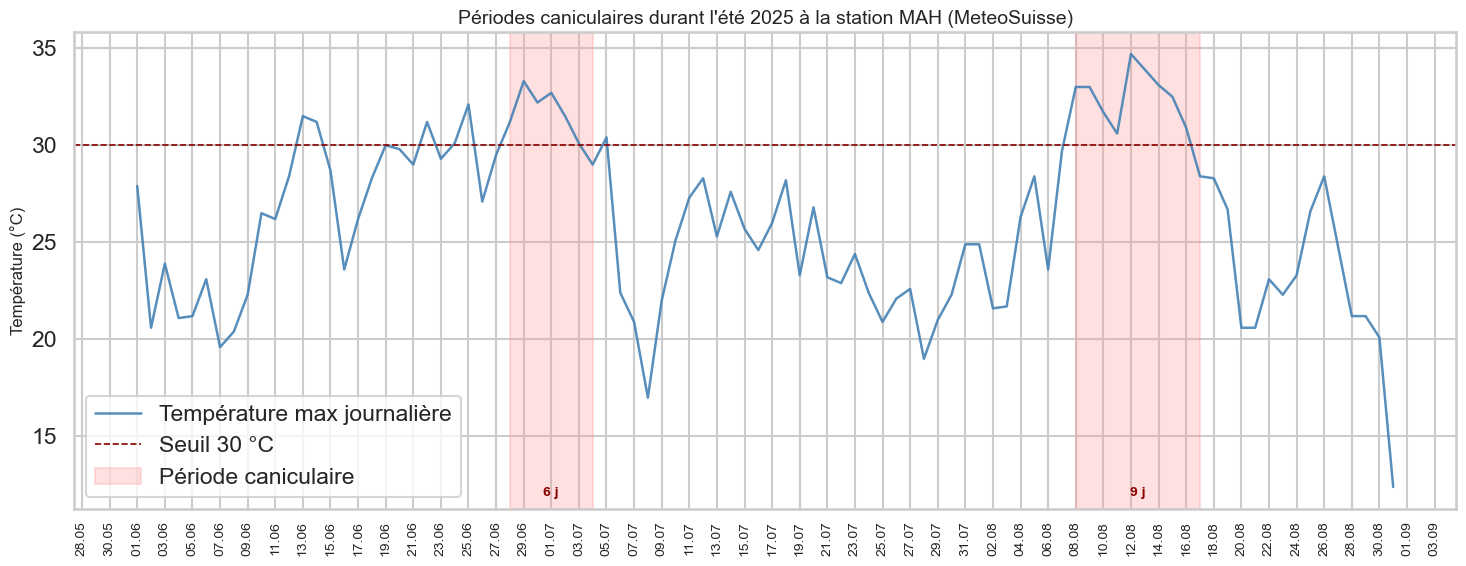

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

def plot_daily_max_with_heatwaves(df, heatwaves, start_date=None, end_date=None, station_abbr='MAH'):
    """
    df: DataFrame horaire avec colonnes ['datetime','temperature','source','station_abbr']
    heatwaves: DataFrame issu de detect_hot_periods avec 'start_date' et 'end_date'
    start_date: optionnel, datetime-like pour filtrer le début du tracé
    end_date: optionnel, datetime-like pour filtrer la fin du tracé
    """
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6))

    # Filtrer MeteoSuisse MAH
    df_filtered = df[(df['source'] == 'MeteoSuisse') & (df['station_abbr'] == station_abbr)].copy()
    df_filtered['datetime'] = pd.to_datetime(df_filtered['datetime'])

    # Appliquer bornes temporelles
    if start_date is not None:
        df_filtered = df_filtered[df_filtered['datetime'] >= pd.to_datetime(start_date)]
    if end_date is not None:
        df_filtered = df_filtered[df_filtered['datetime'] <= pd.to_datetime(end_date)]

    if df_filtered.empty:
        raise ValueError("Aucune donnée MeteoSuisse MAH après filtrage.")

    # Calcul du max journalier
    df_filtered['date'] = df_filtered['datetime'].dt.normalize()
    daily_max = df_filtered.groupby('date')['temperature'].max().reset_index()
    daily_max['date'] = pd.to_datetime(daily_max['date'])

    # Tracé : uniquement max journalier
    plt.plot(daily_max['date'], daily_max['temperature'],
             label='Température max journalière',
             color='steelblue', linewidth=1.8, alpha=0.9)

    # Ligne horizontale seuil 30 °C
    plt.axhline(30, color='darkred', linestyle='--', linewidth=1.2, label='Seuil 30 °C')

    # Zones canicule avec légende
    canicule_color = (1, 0.6, 0.6, 0.3)
    if heatwaves is not None and not heatwaves.empty:
        added_legend = False
        for _, row in heatwaves.iterrows():
            start = pd.to_datetime(row['start_date'])
            end = pd.to_datetime(row['end_date']) + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
            if not added_legend:
                plt.axvspan(start, end, color=canicule_color, label='Période caniculaire')
                added_legend = True
            else:
                plt.axvspan(start, end, color=canicule_color)

            # annotation du nombre de jours consécutifs en bas du graphique
            ymin, ymax = plt.ylim()
            mid = start + (end - start) / 2
            y_text = ymin + 0.02 * (ymax - ymin)
            plt.text(mid, y_text,
                     f"{row['count']} j", ha='center', va='bottom',
                     color='darkred', fontsize=10, fontweight='bold')

    plt.title("Périodes caniculaires durant l'été 2025 à la station MAH (MeteoSuisse)", fontsize=14)
    
    plt.ylabel('Température (°C)', fontsize=12)
    plt.legend()

    # Axe X plus lisible : tick tous les 2 jours
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
   # Orientation + ancrage + rapprochement
    plt.setp(
        ax.get_xticklabels(),
        rotation=90,
        ha="right",
        va="center",
        rotation_mode="anchor",
        fontsize=10,
    )
    ax.tick_params(axis="x", pad=0)  # distance minimale entre labels et axe

    plt.tight_layout()
    plt.show()

# Calculer le max journalier à partir des données horaires
df_ma = combined_df[(combined_df['source'] == 'MeteoSuisse') & (combined_df['station_abbr'] == 'MAH')].copy()
df_ma['datetime'] = pd.to_datetime(df_ma['datetime'])
daily_max = df_ma.groupby(df_ma['datetime'].dt.normalize())['temperature'].max().reset_index()
daily_max.columns = ['date', 'max']

def detect_hot_periods(daily_max_df, threshold=30, min_days=3):
    """
    Détecte les périodes de chaleur où la température max journalière dépasse un seuil
    pendant au moins 'min_days' jours consécutifs.

    daily_max_df : DataFrame avec colonnes ['date','max']
    threshold    : seuil de température (par défaut 30 °C)
    min_days     : nombre minimum de jours consécutifs
    """
    df = daily_max_df.copy()
    df['date'] = pd.to_datetime(df['date']).dt.normalize()
    df = df.sort_values('date').drop_duplicates('date').set_index('date')

    # Créer un index complet pour gérer les jours manquants
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq='D')
    series = pd.Series(False, index=full_idx)

    mask = df['max'] >= threshold
    series.loc[mask.index] = mask.values

    # Identifier les séquences consécutives
    runs = (series != series.shift()).cumsum()
    groups = series.groupby(runs)

    records = []
    for _, g in groups:
        if g.iloc[0]:  # séquence de True
            start = g.index[0]
            end = g.index[-1]
            count = (end - start).days + 1
            if count >= min_days:
                records.append({'start_date': start, 'end_date': end, 'count': count})

    return pd.DataFrame(records)

# Détecter les périodes caniculaires (≥ 30 °C pendant au moins 3 jours consécutifs)
heatwaves = detect_hot_periods(daily_max, threshold=30, min_days=3)

# Exemple d'utilisation :
plot_daily_max_with_heatwaves(combined_df, heatwaves,
                              start_date='2025-06-01',
                              end_date='2025-08-31',
                              station_abbr='MAH')


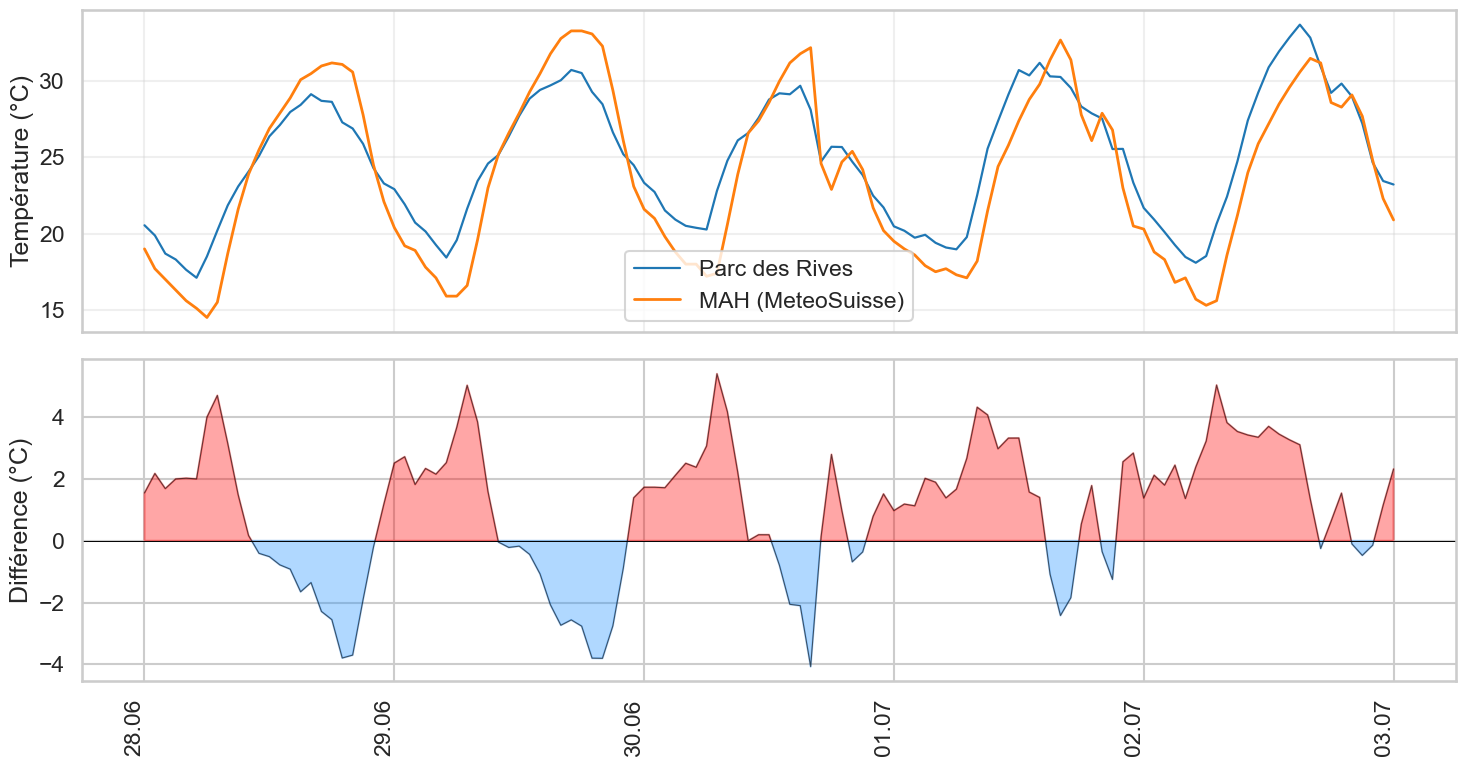

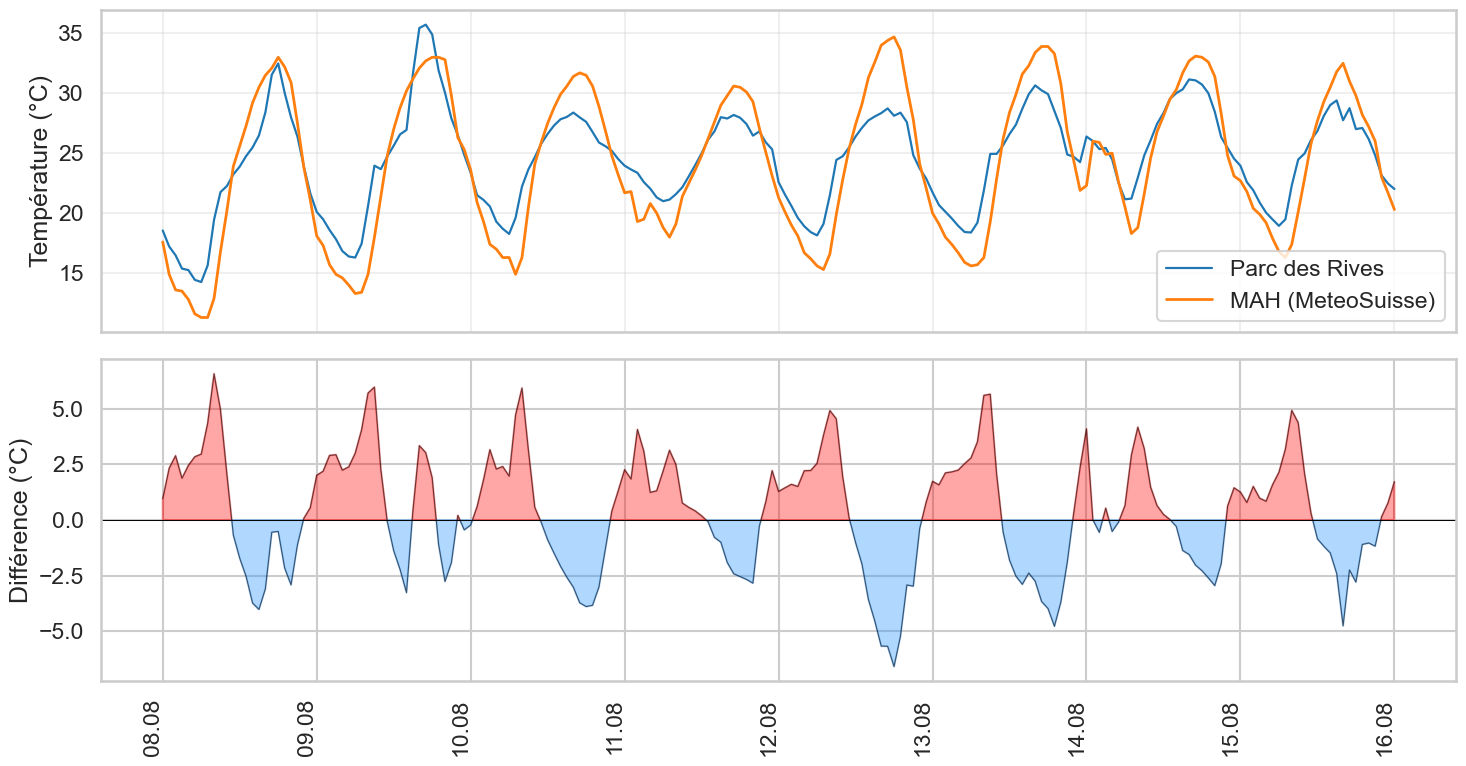

In [46]:
# Graphs avec lignes multiples pour comparaison Decentlab - MeteoSuisse

def plot_multi_panel(combined_df, df2, start_date, end_date):
    """
    Tracé simplifié : 
    - panneau 1 : température station (Decentlab/HOBO) vs MeteoSuisse (MAH)
    - panneau 2 : différence (station - MeteoSuisse) remplie (positif=rouge, négatif=bleu)
    Radiation et précipitation NE SONT PLUS AFFICHÉES.
    """
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import numpy as np

    sns.set_style("whitegrid")

    # créer 2 sous-graphes (température ; différence)
    fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

    # Filtrage des séries
    station_df_filtered = combined_df[
        (combined_df['source'] == selected_source) &
        (combined_df['station'] == selected_station)
    ].copy()
    station_df_filtered = station_df_filtered[
        (station_df_filtered['datetime'] >= pd.to_datetime(start_date)) &
        (station_df_filtered['datetime'] <= pd.to_datetime(end_date))
    ].sort_values('datetime').copy()

    meteo_df_filtered = combined_df[
        (combined_df['source'] == 'MeteoSuisse') &
        (combined_df.get('station_abbr', None) == 'MAH')
    ].copy()
    meteo_df_filtered = meteo_df_filtered[
        (meteo_df_filtered['datetime'] >= pd.to_datetime(start_date)) &
        (meteo_df_filtered['datetime'] <= pd.to_datetime(end_date))
    ].sort_values('datetime').copy()

    if station_df_filtered.empty:
        print(f"Aucune donnée pour la station sélectionnée ({selected_station}) dans la période.")
    if meteo_df_filtered.empty:
        print("Aucune donnée MeteoSuisse (MAH) dans la période.")

    # --- panneau 1 : températures ---
    if not station_df_filtered.empty:
        sns.lineplot(x='datetime', y='temperature', data=station_df_filtered, ax=axes[0], label=selected_station, linewidth=1.6)
    if not meteo_df_filtered.empty:
        sns.lineplot(x='datetime', y='temperature', data=meteo_df_filtered, ax=axes[0], label='MAH (MeteoSuisse)', linewidth=2.0)

    axes[0].set_ylabel('Température (°C)')
    #axes[0].set_title(f'{selected_station} vs MAH (MeteoSuisse)')
    axes[0].legend(title=None)
    axes[0].grid(True, alpha=0.3)

    # --- panneau 2 : différence température station - meteo ---
    if (not station_df_filtered.empty) and (not meteo_df_filtered.empty):
        temp_merge = pd.merge(
            station_df_filtered[['datetime','temperature']],
            meteo_df_filtered[['datetime','temperature']],
            on='datetime', how='inner', suffixes=('_station','_meteo')
        ).dropna()

        if temp_merge.empty:
            print("Aucune correspondance horaire entre station et MeteoSuisse pour la période (join inner).")
        else:
            temp_merge['diff'] = temp_merge['temperature_station'] - temp_merge['temperature_meteo']
            # filled areas
            axes[1].fill_between(temp_merge['datetime'], temp_merge['diff'],
                                 where=(temp_merge['diff'] > 0), color='red', alpha=0.35, interpolate=True)
            axes[1].fill_between(temp_merge['datetime'], temp_merge['diff'],
                                 where=(temp_merge['diff'] < 0), color='dodgerblue', alpha=0.35, interpolate=True)
            axes[1].plot(temp_merge['datetime'], temp_merge['diff'], color='k', linewidth=0.8, alpha=0.6)
            axes[1].axhline(0, color='k', linewidth=0.7)
            axes[1].set_ylabel('Différence (°C)')
            #axes[1].set_title(f'Différence {selected_station} − MAH')

    else:
        axes[1].text(0.5, 0.5, 'Pas assez de données appariées pour tracer la différence', ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_ylabel('Différence (°C)')

    # --- formatage axe X ---
    total_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days + 1
    if total_days <= 31:
        locator = mdates.DayLocator(interval=1)
    elif total_days <= 62:
        locator = mdates.DayLocator(interval=2)
    else:
        interval = max(1, int(np.ceil(total_days / 20)))
        locator = mdates.DayLocator(interval=interval)

    axes[-1].xaxis.set_major_locator(locator)
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
    plt.setp(axes[-1].get_xticklabels(), rotation=90, ha='right')

    #fig.suptitle(f'{selected_station} — période {pd.to_datetime(start_date).date()} → {pd.to_datetime(end_date).date()}', y=0.98)
    plt.tight_layout()
    plt.show()

# Utiliser 'heatwaves' pour tracer les multi-panneaux
if heatwaves is None or heatwaves.empty:
    print("Aucune période caniculaire détectée — rien à tracer.")
else:
    for _, row in heatwaves.iterrows():
        start_date_period = pd.to_datetime(row['start_date'])
        end_date_period = pd.to_datetime(row['end_date'])
        plot_multi_panel(combined_df, dfs['df2'], start_date_period, end_date_period)

In [318]:

def plot_multi_panel_11(
    combined_df,
    stations=("Parc des Rives", "Place Pestalozzi", "Parc d'Entremonts", "Pierre de Savoie"),
    meteo_abbr="MAH",
    start_date="2025-07-02",
    end_date="2025-08-31",
    sources=("Decentlab", "HOBO"),
    xlim_mode="data",  # "data" | "window" | "overlap"
    height_per_station=3.0,
    width=14,
    dpi=140,
    rolling_window=None,   # ex. '30min' ou '1H' pour lisser
):
    """
    Multi-panneaux: à gauche Températures (Station vs MAH), à droite Différence (Station - MAH)
    - Un titre par subplot.
    - Pas de légende.
    - Axe X en 'dd-mm'.
    - Police réduite pour les labels Y.
    """

    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import seaborn as sns

    sns.set_style("whitegrid")
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)

    # MeteoSuisse
    meteo = combined_df[
        (combined_df["source"] == "MeteoSuisse") &
        (combined_df.get("station_abbr") == meteo_abbr)
    ].copy()
    meteo["datetime"] = pd.to_datetime(meteo["datetime"], errors="coerce")
    meteo = meteo.dropna(subset=["datetime", "temperature"])
    meteo = meteo[(meteo["datetime"] >= start) & (meteo["datetime"] <= end)].sort_values("datetime")
    if meteo.empty:
        print(f"Aucune donnée MeteoSuisse {meteo_abbr} entre {start_date} et {end_date}.")
        return None

    # Couleurs par station
    color_map = {
        "Parc des Rives": "dodgerblue",
        "Place Pestalozzi": "red",
        "Parc d'Entremonts": "green",
        "Pierre de Savoie": "gray",
    }

    n = len(stations)
    fig, axes = plt.subplots(
        n, 2,
        figsize=(width, height_per_station * n),
        dpi=dpi,
        constrained_layout=True,
        sharex=False
    )
    if n == 1:
        axes = np.array([axes])

    # Formatter dd-mm
    day_locator = mdates.DayLocator(interval=1)
    ddmm_formatter = mdates.DateFormatter('%d-%m')

    for i, st in enumerate(stations):
        ax_left = axes[i, 0]
        ax_right = axes[i, 1]

        # Station: filtrage & moyenne si plusieurs sources
        st_df = combined_df[
            (combined_df["station"] == st) &
            (combined_df["source"].isin(sources))
        ].copy()
        st_df["datetime"] = pd.to_datetime(st_df["datetime"], errors="coerce")
        st_df = st_df.dropna(subset=["datetime", "temperature"])
        st_df = st_df[(st_df["datetime"] >= start) & (st_df["datetime"] <= end)]
        if st_df.empty:
            ax_left.text(0.5, 0.5, f"Aucune donnée pour {st} dans la période",
                         ha="center", va="center", transform=ax_left.transAxes)
            ax_right.text(0.5, 0.5, "Pas de données appariées",
                          ha="center", va="center", transform=ax_right.transAxes)
            ax_left.set_ylabel("Temp. (°C)", fontsize=10)
            ax_right.set_ylabel("Diff. (°C)", fontsize=10)
            continue

        st_avg = (
            st_df.sort_values("datetime")
                 .groupby("datetime", as_index=False)["temperature"].mean()
                 .rename(columns={"temperature": "temp_st"})
        )

        # Optionnel: lissage
        if rolling_window:
            st_avg = st_avg.set_index("datetime").rolling(rolling_window, min_periods=1).mean().reset_index()

        # Aligner Meteo sur la période station
        meteo_local = meteo.copy()
        if xlim_mode in ("data", "overlap"):
            xmin_st, xmax_st = st_avg["datetime"].min(), st_avg["datetime"].max()
            meteo_local = meteo_local[(meteo_local["datetime"] >= xmin_st) & (meteo_local["datetime"] <= xmax_st)]

        # Tracé Températures
        ax_left.plot(st_avg["datetime"], st_avg["temp_st"],
                     color=color_map.get(st, "black"), linewidth=1.8)
        ax_left.plot(meteo_local["datetime"], meteo_local["temperature"],
                     color="tab:orange", linewidth=1.3, alpha=0.95)

        ax_left.set_ylabel("Température (°C)", fontsize=10)
        ax_left.set_title(f"{st}", fontsize=11)
        ax_left.grid(True, alpha=0.25)

        # y-lim auto avec padding
        y_vals = np.concatenate([
            st_avg["temp_st"].values,
            meteo_local["temperature"].values if not meteo_local.empty else np.array([])
        ])
        if y_vals.size > 0:
            y_min, y_max = np.nanmin(y_vals), np.nanmax(y_vals)
            pad = max(0.5, 0.05 * (y_max - y_min))
            ax_left.set_ylim(y_min - pad, y_max + pad)

        # Différence
        merged = pd.merge(
            st_avg, meteo_local[["datetime", "temperature"]].rename(columns={"temperature": "temp_meteo"}),
            on="datetime", how="inner"
        ).dropna()

        if merged.empty:
            ax_right.text(0.5, 0.5, "Aucune correspondance horaire",
                          ha="center", va="center", transform=ax_right.transAxes)
            ax_right.set_ylabel("Diff. (°C)", fontsize=10)
        else:
            merged["diff"] = merged["temp_st"] - merged["temp_meteo"]
            ax_right.fill_between(
                merged["datetime"], merged["diff"],
                where=(merged["diff"] > 0), interpolate=True, color="salmon", alpha=0.45
            )
            ax_right.fill_between(
                merged["datetime"], merged["diff"],
                where=(merged["diff"] < 0), interpolate=True, color="cornflowerblue", alpha=0.45
            )
            ax_right.plot(merged["datetime"], merged["diff"], color="k", linewidth=0.8, alpha=0.8)
            ax_right.axhline(0, color="k", linewidth=0.7)
            ax_right.set_ylabel("Différence (°C)", fontsize=10)
            ax_right.set_title(f"{st}", fontsize=11)
            ax_right.grid(True, alpha=0.25)

            # y-lim auto avec padding
            y_min, y_max = merged["diff"].min(), merged["diff"].max()
            pad = max(0.5, 0.07 * (y_max - y_min))
            if y_min == y_max:
                y_min -= 1
                y_max += 1
            ax_right.set_ylim(y_min - pad, y_max + pad)

        # Limites X
        if xlim_mode == "window":
            xmin, xmax = start, end
        elif xlim_mode == "overlap":
            if not st_avg.empty and not meteo_local.empty:
                xmin = max(st_avg["datetime"].min(), meteo_local["datetime"].min())
                xmax = min(st_avg["datetime"].max(), meteo_local["datetime"].max())
            else:
                xmin, xmax = st_avg["datetime"].min(), st_avg["datetime"].max()
        else:  # "data"
            xs = []
            if not st_avg.empty: xs.append(st_avg["datetime"])
            if not meteo_local.empty: xs.append(meteo_local["datetime"])
            if len(xs) > 0:
                xmin, xmax = min(s.min() for s in xs), max(s.max() for s in xs)
            else:
                xmin, xmax = start, end

        if pd.isna(xmin) or pd.isna(xmax) or xmin == xmax:
            xmin = start
            xmax = start + pd.Timedelta(hours=6)

        ax_left.set_xlim(xmin, xmax)
        ax_right.set_xlim(xmin, xmax)

        # Axe X: format dd-mm
        for ax in (ax_left, ax_right):
            ax.xaxis.set_major_locator(day_locator)
            ax.xaxis.set_major_formatter(ddmm_formatter)
            for label in ax.get_xticklabels():
                label.set_rotation(0)
                label.set_horizontalalignment('center')
                ax.tick_params(axis='x', labelsize=10)  # taille des ticks X
                ax.tick_params(axis='y', labelsize=10)  # taille des ticks Y
                ax_right.set_yticks([-8, -6, -4, -2, 0, 2, 4, 6, 8])

   


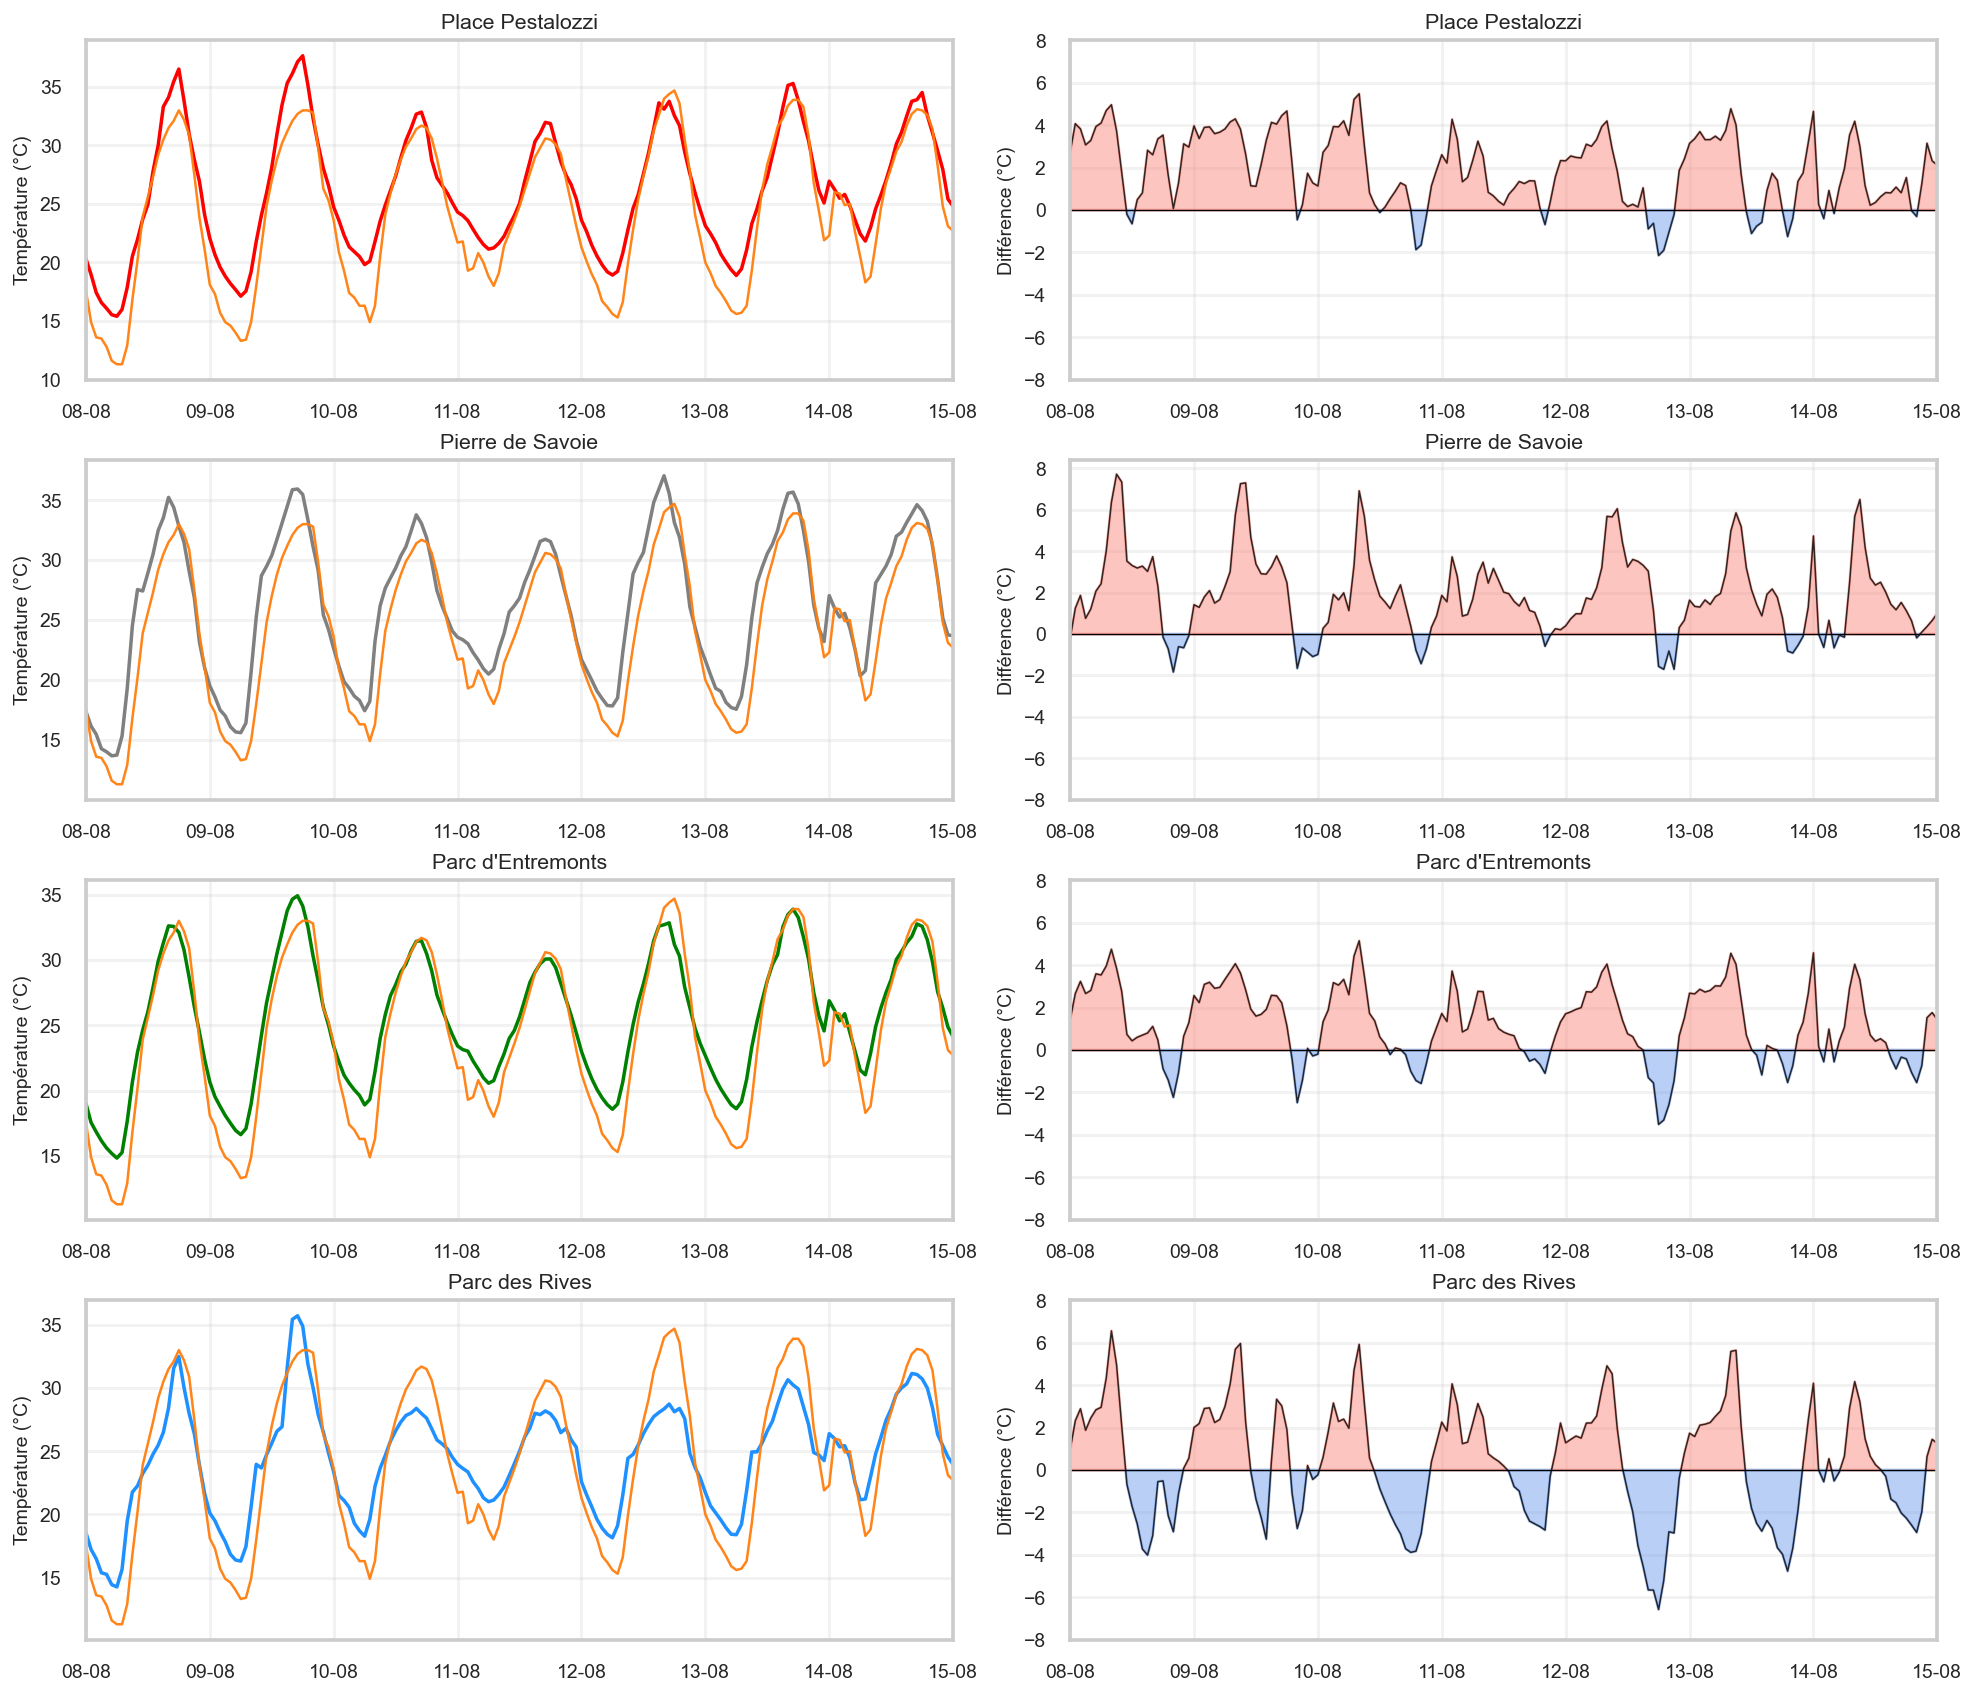

In [319]:
plot_multi_panel_11(
    combined_df,
    stations=["Place Pestalozzi","Pierre de Savoie","Parc d'Entremonts","Parc des Rives"],
    meteo_abbr="MAH",
    start_date="2025-08-08",
    end_date="2025-08-15",    # limite par panneau selon données réelles
    height_per_station=3.0,
    width=14,
       dpi=140,
    rolling_window=None  # ou '1H' si tu veux lisser
)

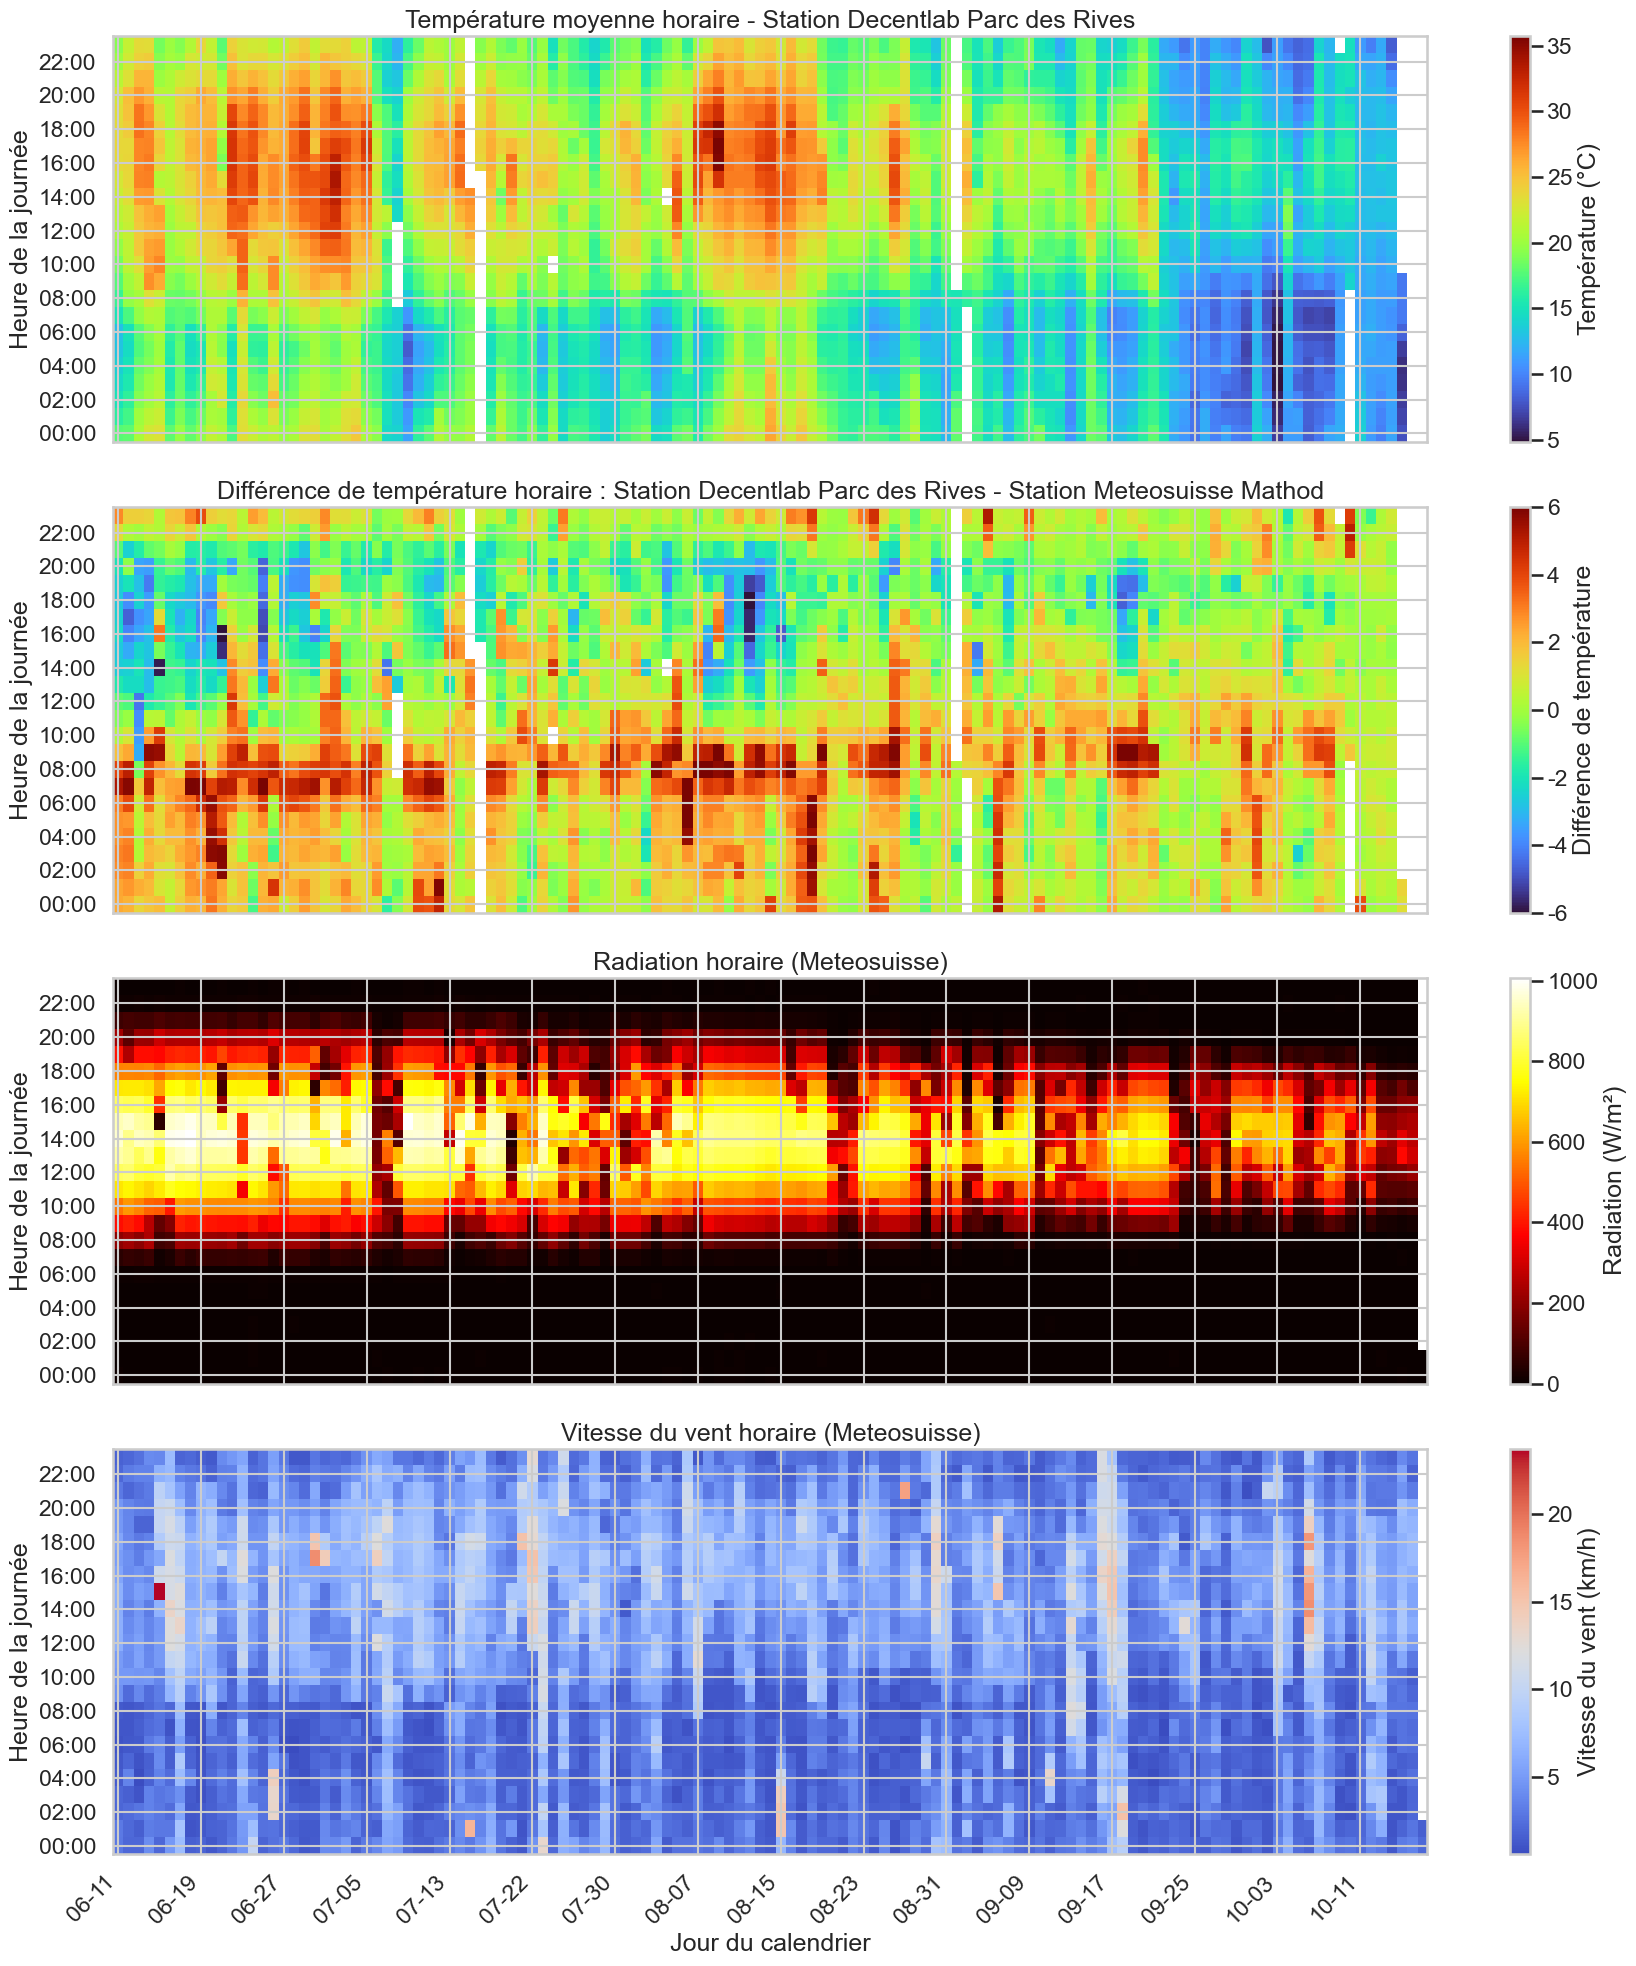

In [320]:
#Graph heatmap

import matplotlib.colors as mcolors

def plot_hourly_mean_and_diff_heatmap(
    df, temp_diff_df, meteo_df=None, value_col='temperature'
):
    """
    Affiche plusieurs heatmaps :
    1. Température moyenne horaire
    2. Différence de température horaire 
    3. Radiation 
    4. Vitesse du vent 
    """

    # --- Préparation température ---
    df = df[df['datetime'] >= pd.to_datetime('2025-06-11')].copy()
    df['date'] = df['datetime'].dt.date
    df['hour'] = df['datetime'].dt.hour
    pivot1 = df.pivot_table(index='hour', columns='date', values=value_col, aggfunc='mean')

    # --- Préparation différence de température ---
    temp_diff_df = temp_diff_df[temp_diff_df['datetime'] >= pd.to_datetime('2025-06-11')].copy()
    temp_diff_df['date'] = temp_diff_df['datetime'].dt.date
    temp_diff_df['hour'] = temp_diff_df['datetime'].dt.hour
    pivot2 = temp_diff_df.pivot_table(index='hour', columns='date', values='temperature_difference', aggfunc='mean')

    # --- Préparation radiation et vent si meteo_df fourni ---
    n_subplots = 2
    pivot_rad = None
    pivot_wind = None
    if meteo_df is not None:
        meteo_df = meteo_df[meteo_df['datetime'] >= pd.to_datetime('2025-06-11')].copy()
        meteo_df['date'] = meteo_df['datetime'].dt.date
        meteo_df['hour'] = meteo_df['datetime'].dt.hour
        # Radiation
        if 'gre000h0' in meteo_df.columns:
            pivot_rad = meteo_df.pivot_table(index='hour', columns='date', values='gre000h0', aggfunc='mean')
            n_subplots += 1
        # Vent (colonne fixée à 'fkl010h1')
        if 'fkl010h1' in meteo_df.columns:
            pivot_wind = meteo_df.pivot_table(index='hour', columns='date', values='fkl010h1', aggfunc='mean')
            n_subplots += 1

    fig, axes = plt.subplots(n_subplots, 1, figsize=(18, 5*n_subplots), sharex=True)

    # Température
    im1 = axes[0].imshow(pivot1, aspect='auto', cmap='turbo', origin='lower')
    plt.colorbar(im1, ax=axes[0], label="Température (°C)")
    axes[0].set_yticks(np.arange(0, 24, 2))
    axes[0].set_yticklabels([f"{h:02d}:00" for h in range(0, 24, 2)])
    axes[0].set_ylabel("Heure de la journée")
    axes[0].set_title(f"Température moyenne horaire - Station Decentlab {selected_station}")

    # Différence de température
    
    norm = mcolors.TwoSlopeNorm(vmin=-6, vcenter=0, vmax=6)
    im2 = axes[1].imshow(
        pivot2,
        aspect='auto',
        cmap='turbo',
        origin='lower',
        norm=norm
    )
    cbar = plt.colorbar(im2, ax=axes[1], label="Différence de température")
    cbar.set_ticks([-6, -4, -2, 0, 2, 4, 6])
    cbar.ax.set_yticklabels(['-6', '-4', '-2', '0', '2', '4', '6'])
    axes[1].set_yticks(np.arange(0, 24, 2))
    axes[1].set_yticklabels([f"{h:02d}:00" for h in range(0, 24, 2)])
    axes[1].set_ylabel("Heure de la journée")
    axes[1].set_title(f"Différence de température horaire : Station Decentlab {selected_station} - Station Meteosuisse Mathod")

    idx = 2
    # Radiation
    if pivot_rad is not None:
        im3 = axes[idx].imshow(pivot_rad, aspect='auto', cmap='hot', origin='lower')
        plt.colorbar(im3, ax=axes[idx], label="Radiation (W/m²)")
        axes[idx].set_yticks(np.arange(0, 24, 2))
        axes[idx].set_yticklabels([f"{h:02d}:00" for h in range(0, 24, 2)])
        axes[idx].set_ylabel("Heure de la journée")
        axes[idx].set_title("Radiation horaire (Meteosuisse)")
        idx += 1

    # Vent (fkl010h1)
    if pivot_wind is not None:
        im4 = axes[idx].imshow(pivot_wind, aspect='auto', cmap='coolwarm', origin='lower')
        plt.colorbar(im4, ax=axes[idx], label="Vitesse du vent (km/h)")
        axes[idx].set_yticks(np.arange(0, 24, 2))
        axes[idx].set_yticklabels([f"{h:02d}:00" for h in range(0, 24, 2)])
        axes[idx].set_ylabel("Heure de la journée")
        axes[idx].set_title("Vitesse du vent horaire (Meteosuisse)")

    # X ticks partagés
    xticks = np.arange(0, pivot1.shape[1], max(1, pivot1.shape[1] // 15))
    xlabels = [str(d)[5:] for i, d in enumerate(pivot1.columns) if i % max(1, pivot1.shape[1] // 15) == 0]
    for ax in axes:
        ax.set_xticks(xticks)
        ax.set_xticklabels(xlabels, rotation=45, ha='right')
    axes[-1].set_xlabel("Jour du calendrier")

    plt.tight_layout()
    plt.show()

# --- Construction du DataFrame de différence de température ---
station_df_filtered = combined_df[(combined_df['source'] == selected_source) & (combined_df['station'] == selected_station)].copy()
meteo_df_filtered = combined_df[(combined_df['source'] == 'MeteoSuisse') & (combined_df['station_abbr'] == 'MAH')].copy()
temp_diff_df = pd.merge(
    station_df_filtered[['datetime', 'temperature']],
    meteo_df_filtered[['datetime', 'temperature']],
    on='datetime',
    suffixes=('_station', '_meteo')
)
temp_diff_df['temperature_difference'] = temp_diff_df['temperature_station'] - temp_diff_df['temperature_meteo']

# Utilisation :
plot_hourly_mean_and_diff_heatmap(station_df_filtered, temp_diff_df, meteo_df=meteo_df_filtered)

In [321]:
def tropical_counts_table_enhanced(
        combined_df,
        start_date='2025-06-01',
        end_date='2025-08-31',
        sources=('Decentlab', 'HOBO'),
        reference_abbr='MAH',
        save_path=r"C:\Users\vincent.destaerc\Documents\GitHub\Yverdon_les_tropiques\Export csv\tropical_counts_juin_aout_2025.csv"):

    import pandas as pd
    import numpy as np

    # --- Préparation du dataframe ---
    df_all = combined_df.copy()
    df_all['datetime'] = pd.to_datetime(df_all['datetime'], errors='coerce')

    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date) + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)

    # Filtre uniquement les sources d'intérêt
    df = df_all[
        df_all['source'].isin(sources)
        & (df_all['datetime'].between(start, end))
    ].dropna(subset=['station', 'temperature', 'datetime'])

    if df.empty:
        print("Aucune donnée disponible pour les sources et la période spécifiées.")
        return pd.DataFrame()

    # --- Période commune initiale ---
    date_ranges = (
        df.groupby(['source', 'station'])['datetime']
        .agg(min_dt='min', max_dt='max')
        .reset_index()
    )
    date_ranges['min_date'] = date_ranges['min_dt'].dt.date
    date_ranges['max_date'] = date_ranges['max_dt'].dt.date

    common_start = pd.to_datetime(date_ranges['min_date'].max())
    common_end = pd.to_datetime(date_ranges['max_date'].min())

    if (pd.isna(common_start) or pd.isna(common_end) or common_start > common_end):
        print("Aucune période commune trouvée entre les stations.")
        return pd.DataFrame()

    print(f"Période commune détectée : {common_start.date()} → {common_end.date()}")

    # --- Intersection stricte de dates ---
    df['date_only'] = df['datetime'].dt.date

    dec_dates = set(df.loc[df['source'] == 'Decentlab', 'date_only'])
    hobo_dates = set(df.loc[df['source'] == 'HOBO', 'date_only'])
    common_dates = sorted(dec_dates & hobo_dates)

    if len(common_dates) == 0:
        print("Aucune date commune entre Decentlab et HOBO.")
        return pd.DataFrame()

    df = df[df['date_only'].isin(common_dates)].copy()
    df['date'] = pd.to_datetime(df['date_only'])

    # --- Statistiques journalières ---
    daily = (
        df.groupby(['source', 'station', 'date'])['temperature']
        .agg(min='min', max='max', mean='mean')
        .reset_index()
    )

    # --- Données de référence MeteoSuisse ---
    ref = df_all[
        (df_all['source'] == 'MeteoSuisse') &
        (df_all.get('station_abbr') == reference_abbr)
    ].dropna(subset=['datetime', 'temperature'])

    ref = ref[
        ref['datetime'].dt.date.astype('datetime64[D]').between(common_start, common_end)
    ]

    if not ref.empty:
        ref['date'] = ref['datetime'].dt.floor('D')
        ref_daily = (
            ref.groupby('date')['temperature']
            .mean()
            .reset_index()
            .rename(columns={'temperature': 'temp_ref'})
        )
        ref_hourly = ref[['datetime', 'temperature']].rename(columns={'temperature': 'temp_ref'})
    else:
        ref_daily = pd.DataFrame(columns=['date', 'temp_ref'])
        ref_hourly = pd.DataFrame(columns=['datetime', 'temp_ref'])

    # --- Calcul des métriques par station ---
    results = []

    for (source, station), g in daily.groupby(['source', 'station']):

        avg_temp = round(g['mean'].mean(), 2)
        max_temp = round(g['max'].max(), 2)
        min_temp = round(g['min'].min(), 2)

        nights_tropical = int((g['min'] > 20).sum())
        days_tropical = int((g['max'] > 30).sum())

        # --- Comparaison avec MeteoSuisse ---
        mean_diff_vs_ref = np.nan
        mean_diff_day = np.nan
        mean_diff_night = np.nan

        # Comparaison journalière
        if not ref_daily.empty:
            station_daily = g[['date', 'mean']].rename(columns={'mean': 'temp_st'})
            merged_daily = station_daily.merge(ref_daily, on='date', how='inner')

            if not merged_daily.empty:
                mean_diff_vs_ref = round((merged_daily['temp_st'] - merged_daily['temp_ref']).mean(), 2)

        # Comparaison horaire jour/nuit
        st_hourly = df[(df['source'] == source) & (df['station'] == station)]
        if not st_hourly.empty and not ref_hourly.empty:
            merged_hourly = (
                st_hourly[['datetime', 'temperature']]
                .rename(columns={'temperature': 'temp_st'})
                .merge(ref_hourly, on='datetime', how='inner')
                .dropna()
            )

            if not merged_hourly.empty:
                hrs = merged_hourly['datetime'].dt.hour
                day_mask = hrs.between(6, 22)
                night_mask = ~day_mask

                if merged_hourly.loc[day_mask].size > 0:
                    mean_diff_day = round(
                        (merged_hourly.loc[day_mask, 'temp_st'] -
                         merged_hourly.loc[day_mask, 'temp_ref']).mean(), 2
                    )
                if merged_hourly.loc[night_mask].size > 0:
                    mean_diff_night = round(
                        (merged_hourly.loc[night_mask, 'temp_st'] -
                         merged_hourly.loc[night_mask, 'temp_ref']).mean(), 2
                    )

        # --- Stockage ---
        results.append({
            'source': source,
            'station': station,
            'avg_temp': avg_temp,
            'max_temp': max_temp,
            'min_temp': min_temp,
            'nights_tropical': nights_tropical,
            'days_tropical': days_tropical,
            'mean_diff_vs_meteosuisse': mean_diff_vs_ref,
            'mean_diff_day_vs_meteosuisse': mean_diff_day,
            'mean_diff_night_vs_meteosuisse': mean_diff_night
        })

    result = pd.DataFrame(results).sort_values(['source', 'station']).reset_index(drop=True)

    # --- Export CSV ---
    if save_path and not result.empty:
        result.to_csv(save_path, index=False, sep=';')
        print(f"Tableau sauvegardé dans : {save_path}")

    return result


In [322]:
# Statistiques période caniculaire

def heatwave_stats(combined_df,
                   start='2025-08-08',
                   end='2025-08-17',
                   sources=('Decentlab', 'HOBO'),
                   reference_abbr='MAH'):
    import pandas as pd
    import numpy as np

    df = combined_df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
    df = df.dropna(subset=['temperature', 'datetime'])

    # Définition période (inclut toute la journée de 'end')
    start = pd.to_datetime(start)
    end = pd.to_datetime(end) + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)

    # Référence MeteoSuisse
    ref = df[
        (df['source'] == 'MeteoSuisse') &
        (df.get('station_abbr') == reference_abbr) &
        df['datetime'].between(start, end)
    ].copy()

    if ref.empty:
        print("⚠️ Aucune donnée MeteoSuisse pour la période.")
        return pd.DataFrame()

    ref = ref.rename(columns={'temperature': 'temp_ref'})
    ref['date'] = ref['datetime'].dt.date

    # Données stations Decentlab / HOBO
    st = df[
        df['source'].isin(sources) &
        df['datetime'].between(start, end)
    ].copy()
    if st.empty:
        print("⚠️ Aucune donnée Decentlab/HOBO pour la période.")
        return pd.DataFrame()

    st = st.rename(columns={'temperature': 'temp_station'})
    st['date'] = st['datetime'].dt.date

    results = []

    for (source, station), g in st.groupby(['source', 'station']):
        # 1) Différence sur Tmax journalière
        tx_station = g.groupby('date')['temp_station'].max()
        tx_ref = ref.groupby('date')['temp_ref'].max()

        tx_merged = pd.DataFrame({'tx_station': tx_station}).join(
            pd.DataFrame({'tx_ref': tx_ref}), how='inner'
        )
        diff_tx = np.nan
        if not tx_merged.empty:
            diff_tx = round((tx_merged['tx_station'] - tx_merged['tx_ref']).mean(), 2)

        # 2) Différence DIURNE (06:00-22:00) et NOCTURNE
        merged_hr = g[['datetime', 'temp_station']].merge(
            ref[['datetime', 'temp_ref']], on='datetime', how='inner'
        ).dropna()

        mean_diff_day = np.nan
        mean_diff_night = np.nan
        if not merged_hr.empty:
            hrs = merged_hr['datetime'].dt.hour
            day_mask = hrs.between(6, 22)   # inclus 06–22
            night_mask = ~day_mask

            if merged_hr.loc[day_mask].shape[0] > 0:
                mean_diff_day = round(
                    (merged_hr.loc[day_mask, 'temp_station'] - merged_hr.loc[day_mask, 'temp_ref']).mean(), 2
                )
            if merged_hr.loc[night_mask].shape[0] > 0:
                mean_diff_night = round(
                    (merged_hr.loc[night_mask, 'temp_station'] - merged_hr.loc[night_mask, 'temp_ref']).mean(), 2
                )

        # Couverture journalière (jours avec données) et métriques simples
        daily = g.groupby('date')['temp_station'].agg(min_st='min', max_st='max', mean_st='mean').reset_index()
        days_with_data = int(daily['date'].nunique()) if not daily.empty else 0
        avg_temp = round(daily['mean_st'].mean(), 2) if not daily.empty else np.nan
        max_temp = round(daily['max_st'].max(), 2) if not daily.empty else np.nan
        min_temp = round(daily['min_st'].min(), 2) if not daily.empty else np.nan
        nights_tropical = int((daily['min_st'] > 20).sum()) if not daily.empty else 0
        days_tropical = int((daily['max_st'] > 30).sum()) if not daily.empty else 0

        results.append({
            'source': source,
            'station': station,
            'avg_temp': avg_temp,
            'max_temp': max_temp,
            'min_temp': min_temp,
            'nights_tropical': nights_tropical,
            'days_tropical': days_tropical,
            'mean_diff_Tmax_vs_ref': diff_tx,
            'mean_diff_day_vs_ref': mean_diff_day,
            'mean_diff_night_vs_ref': mean_diff_night,
            'days_with_data': days_with_data
        })

    result = pd.DataFrame(results).sort_values(['source', 'station']).reset_index(drop=True)
    return result

# Calcul des statistiques de canicule
resultats_canicule = heatwave_stats(combined_df)
print(resultats_canicule)

# Chemin d'export CSV
save_path = r"C:\Users\vincent.destaerc\Documents\GitHub\Yverdon_les_tropiques\Export csv\heatwave_stats_2025.csv"

# --- Export CSV ---
if save_path and not resultats_canicule.empty:
    resultats_canicule.to_csv(save_path, index=False, sep=';')
    print(f"Tableau sauvegardé dans : {save_path}")


       source             station  avg_temp  max_temp  min_temp  \
0   Decentlab           Cimetière     25.53     36.62     13.78   
1   Decentlab     Jardin de Poche     25.19     34.94     14.33   
2   Decentlab   Parc d'Entremonts     25.17     34.92     14.84   
3   Decentlab      Parc des Rives     24.44     35.72     14.26   
4   Decentlab    Pierre de Savoie     25.77     37.04     13.67   
5   Decentlab    Place Pestalozzi     25.79     37.67     15.40   
6   Decentlab        Place d'Arme     25.84     36.29     15.13   
7   Decentlab  Platane du Château     25.50     37.23     14.85   
8   Decentlab    Rue de la Plaine     26.05     36.71     15.03   
9        HOBO           Haldimand     25.97     36.59     15.02   
10       HOBO             Hopital     25.90     35.43     14.99   
11       HOBO           Les Isles     25.40     36.82     13.76   
12       HOBO              Parcst     25.89     36.48     14.29   
13       HOBO         Pres Du Lac     24.88     36.18     14.0

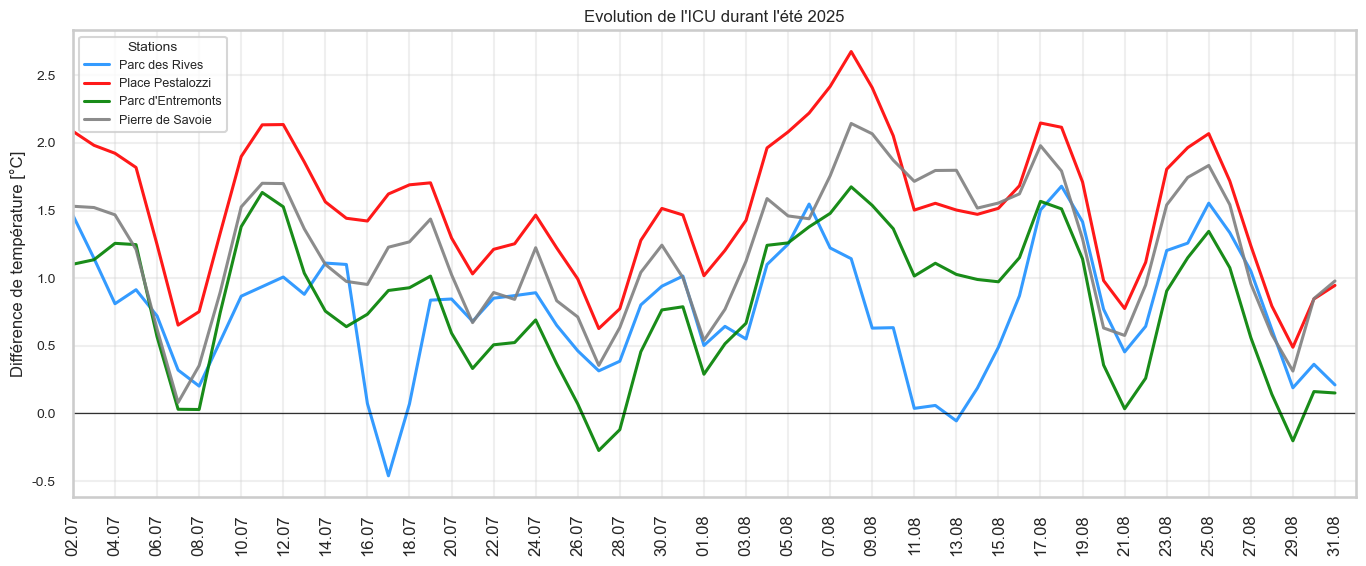

In [323]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns

def plot_diff_evolution(combined_df,
                        stations = ["Parc des Rives", "Place Pestalozzi", "Parc d'Entremonts", "Pierre de Savoie"],
                        meteo_abbr = "MAH",
                        start_date = "2025-07-02",
                        end_date = "2025-08-31",
                        resample = "D",
                        smooth_window = 3,
                        show_counts_secondary = False):
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)  # borne finale à minuit du 31.08

    if 'station_abbr' in combined_df.columns:
        meteo_mask = (combined_df['source'] == 'MeteoSuisse') & (combined_df['station_abbr'] == meteo_abbr)
    else:
        meteo_mask = (combined_df['source'] == 'MeteoSuisse')

    meteo = combined_df[meteo_mask][['datetime','temperature']].dropna().copy()
    meteo = meteo[(meteo['datetime'] >= start) & (meteo['datetime'] < end + pd.Timedelta(days=1))].sort_values('datetime')
    if meteo.empty:
        print(f"Aucune donnée MeteoSuisse pour {meteo_abbr} dans la période {start_date} → {end_date}.")
        return None

    palette = sns.color_palette("tab10")
    color_map = {
    "Parc des Rives": "dodgerblue",          # reste en bleu
    "Place Pestalozzi": "red",         # forcé en rouge
    "Parc d'Entremonts": "green",      # reste en vert
    "Pierre de Savoie": "gray"         # forcé en gris
    }


    all_dfs = []
    for st in stations:
        st_df = combined_df[
            (combined_df['station'] == st) &
            (combined_df['source'].isin(['Decentlab','HOBO']))
        ][['datetime','temperature']].dropna().copy()

        st_df = st_df[(st_df['datetime'] >= start) & (st_df['datetime'] < end + pd.Timedelta(days=1))].sort_values('datetime')
        if st_df.empty:
            print(f"Aucune donnée pour la station '{st}' dans la période — ignorée.")
            continue

        merged = pd.merge(
            st_df.rename(columns={'temperature':'temp_st'}),
            meteo.rename(columns={'temperature':'temp_meteo'}),
            on='datetime', how='inner'
        ).dropna()

        if merged.empty:
            print(f"Aucune correspondance horaire entre '{st}' et MeteoSuisse — ignorée.")
            continue

        merged['diff'] = merged['temp_st'] - merged['temp_meteo']
        merged = merged.set_index('datetime')

        if resample is not None:
            agg = merged['diff'].resample(resample).mean()
            cnt = merged['diff'].resample(resample).count()
            df_out = pd.DataFrame({'diff': agg, 'count': cnt})
        else:
            df_out = merged[['diff']].copy()
            df_out['count'] = 1

        df_out['station'] = st
        all_dfs.append(df_out.reset_index())

    if len(all_dfs) == 0:
        print("Aucune série appariée à tracer.")
        return None

    plot_df = pd.concat(all_dfs, ignore_index=True)
    if plot_df.empty:
        print("Données résultantes vides après concaténation.")
        return None

    x_min = start
    x_max = end + pd.Timedelta(hours=23, minutes=59, seconds=59)  # borne finale stricte
    total_days = max(1, (end - start).days + 1)

    plot_df = plot_df.sort_values(['station','datetime'])
    if smooth_window and smooth_window > 1:
        plot_df['diff_smooth'] = plot_df.groupby('station')['diff'].transform(
            lambda s: s.rolling(window=smooth_window, min_periods=1, center=True).mean()
        )
    else:
        plot_df['diff_smooth'] = plot_df['diff']

    sns.set_style("whitegrid")
    sns.set_context("talk")

    fig, ax = plt.subplots(figsize=(14,6))
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))

    ax2 = None
    if show_counts_secondary and resample is not None:
        ax2 = ax.twinx()
        ax2.set_ylabel("Nombre de points par période", fontsize=9)
        ax2.grid(False)
        ax2.set_alpha(0.8)
        ax2.tick_params(axis='y', labelsize=10)

    for i, st in enumerate(stations):
        sub = plot_df[plot_df['station'] == st]
        if sub.empty:
            continue
        color = color_map.get(st, palette[i % len(palette)])
        ax.plot(sub['datetime'], sub['diff_smooth'],
                label=st, linewidth=2.2, color=color, alpha=0.9)

        if ax2 is not None:
            ax2.plot(sub['datetime'], sub['count'],
                     color=color, alpha=0.5, linewidth=1.4, linestyle='--')

    ax.axhline(0, color='k', linewidth=0.9, alpha=0.8)
    ax.set_ylabel("Différence de température [°C]", fontsize=12)
    ax.set_title("Evolution de l'ICU durant l'été 2025", fontsize=12)

    ax.legend(title="Stations", loc='upper left', frameon=True, fontsize=9, title_fontsize=10)
    ax.grid(True, alpha=0.3)

    # Ticks X
    if resample == 'D':
        if total_days <= 31:
            locator = mdates.DayLocator(interval=1)
        elif total_days <= 62:
            locator = mdates.DayLocator(interval=2)
        else:
            approx_ticks = 20
            interval = max(1, int(np.ceil(total_days / approx_ticks)))
            locator = mdates.DayLocator(interval=interval)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
    else:
        ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[0,6,12,18]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m\n%H:%M'))

    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    plt.setp(
        ax.get_xticklabels(),
        rotation=90,
        ha="right",
        va="center",
        rotation_mode="anchor",
        fontsize=12,
    )

    # Limites strictes
    ax.set_xlim(x_min, x_max)
    ax.set_xbound(x_min, x_max)
    ax.margins(x=0)
    ax.set_autoscale_on(False)

    plt.tight_layout()
    plt.show()

    return plot_df
# Exemple d'exécution (ajuste la période si besoin)
# Assure-toi d'avoir `combined_df` dans l'espace de travail (ex: résultat de preprocess_data)
plot_df = plot_diff_evolution(combined_df,
    stations=["Parc des Rives", "Place Pestalozzi", "Parc d'Entremonts", "Pierre de Savoie"],
     meteo_abbr="MAH",
     start_date="2025-07-02",
     end_date="2025-08-31",
    resample="D",
     smooth_window=3,
     show_counts_secondary=False
 )

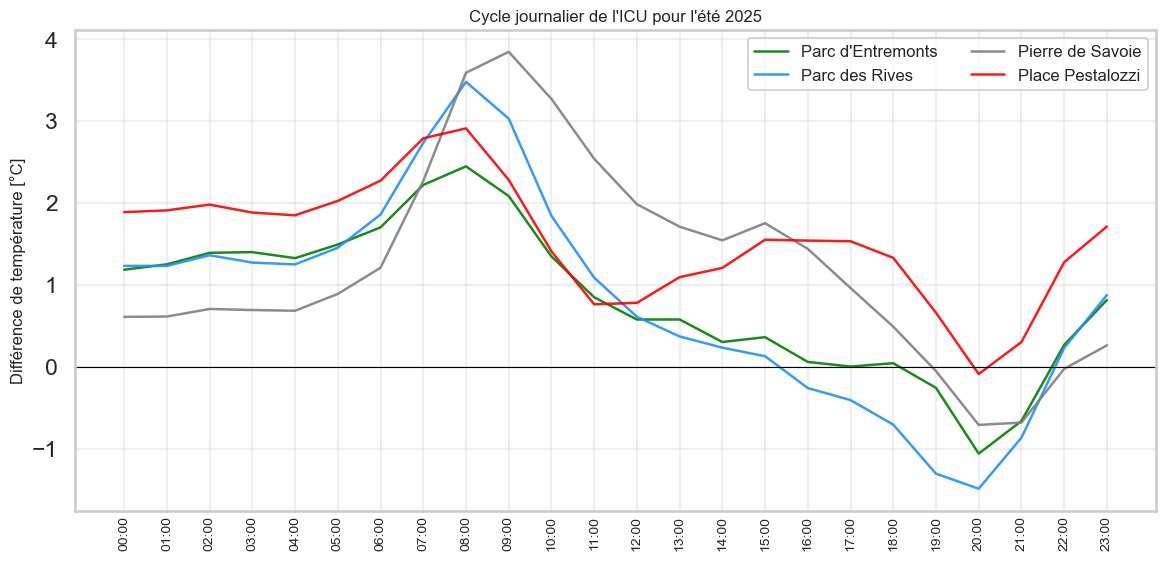

In [324]:
def plot_daily_cycle_mean_diff(
    combined_df,
    meteo_abbr="MAH",
    start_date="2025-07-02",
    end_date="2025-08-31",
    tol="30min"
):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # --- Préparation des bornes temporelles ---
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date) + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)

    # --- Données de référence MeteoSuisse ---
    meteo = (
        combined_df.query("source == 'MeteoSuisse' and station_abbr == @meteo_abbr")
        [["datetime", "temperature"]]
        .dropna()
        .sort_values("datetime")
    )
    if meteo.empty:
        print(f"Aucune donnée MeteoSuisse pour {meteo_abbr}")
        return

    # --- Stations à comparer (filtrage explicite) ---
    target_stations = [
        "Parc des Rives",
        "Pierre de Savoie",
        "Place Pestalozzi",
        "Parc d'Entremonts",
    ]
    stations = (
        combined_df.loc[combined_df["source"].isin(["Decentlab", "HOBO"]), "station"]
        .dropna()
        .unique()
    )
    stations = [st for st in stations if st in target_stations]

    hours = np.arange(24)
    mean_table = pd.DataFrame(index=hours)

    # --- Boucle sur les stations filtrées ---
    for st in stations:
        st_df = (
            combined_df.query("source in ['Decentlab','HOBO'] and station == @st")
            [["datetime", "temperature"]]
            .dropna()
            .query("@start <= datetime <= @end")
            .sort_values("datetime")
        )
        if st_df.empty:
            continue

        merged = pd.merge_asof(
            st_df,
            meteo,
            on="datetime",
            direction="nearest",
            tolerance=pd.Timedelta(tol),
            suffixes=("_station", "_meteo"),
        ).dropna(subset=["temperature_meteo"])

        if merged.empty:
            continue

        merged["hour"] = merged["datetime"].dt.hour
        merged["diff"] = merged["temperature_station"] - merged["temperature_meteo"]

        grp = merged.groupby("hour")["diff"]
        mean_table[st] = grp.mean().reindex(hours)

    if mean_table.empty:
        print("Aucune station avec données appariées.")
        return

    # --- Tracé ---
    color_map = {
        "Parc des Rives": "dodgerblue",
        "Place Pestalozzi": "red",
        "Parc d'Entremonts": "green",
        "Pierre de Savoie": "gray",
    }

    fig, ax = plt.subplots(figsize=(12, 6))
    for st in mean_table.columns:
        ax.plot(
            hours,
            mean_table[st],
            label=st,
            linewidth=1.8,
            alpha=0.9,
            color=color_map.get(st, "black"),
        )

    # Ticks et labels X: vertical et rapprochés du cadre
    ax.set_xticks(hours)
    labels = [f"{h:02d}:00" for h in hours]
    ax.set_xticklabels(labels)  # assigne d'abord les labels

    # Orientation + ancrage + rapprochement
    plt.setp(
        ax.get_xticklabels(),
        rotation=90,
        ha="right",
        va="center",
        rotation_mode="anchor",
        fontsize=10,
    )
    ax.tick_params(axis="x", pad=-5)  # distance minimale entre labels et axe

    ax.axhline(0, color="k", linewidth=0.8)
    
    ax.set_ylabel("Différence de température [°C]", fontsize=12)
    ax.set_title("Cycle journalier de l'ICU pour l'été 2025", fontsize=12)
    ax.legend(ncol=2, fontsize=12)
    ax.grid(True, alpha=0.3)

    # Marges pour éviter la coupe des labels tout en restant proche du cadre
    fig.tight_layout()
    plt.subplots_adjust(bottom=0.12)

    plt.show()
plot_daily_cycle_mean_diff(combined_df, meteo_abbr='MAH', start_date='2025-07-02', end_date='2025-08-31', tol='30min')

In [ ]:
def heat_index_from_T_RH_C(T_C, RH):
    import numpy as np
    T_C = np.asarray(T_C, dtype=float)
    RH = np.asarray(RH, dtype=float)

    # conversion en °F
    T = T_C * 9.0/5.0 + 32.0
    mask_invalid = np.isnan(T) | np.isnan(RH)
    HI = np.full_like(T, np.nan, dtype=float)

    # coefficients Rothfusz
    a = -42.379; b = 2.04901523; c = 10.14333127; d = -0.22475541
    e = -0.00683783; f = -0.05481717; g = 0.00122874; h = 0.00085282; i = -0.00000199

    HI_all = (a + b*T + c*RH + d*T*RH + e*T*T + f*RH*RH +
              g*T*T*RH + h*T*RH*RH + i*T*T*RH*RH)

    # ajustements pour humidité très basse/haute
    adj = np.zeros_like(HI_all)
    cond_low = (RH < 13) & (T >= 80) & (T <= 112)
    adj[cond_low] = -((13.0 - RH[cond_low]) / 4.0) * np.sqrt((17.0 - np.abs(T[cond_low] - 95.0)) / 17.0)
    cond_high = (RH > 85) & (T >= 80) & (T <= 87)
    adj[cond_high] = ((RH[cond_high] - 85.0) / 10.0) * ((87.0 - T[cond_high]) / 5.0)

    HI_F = HI_all + adj
    HI_C = (HI_F - 32.0) * 5.0/9.0

    HI[~mask_invalid] = HI_C[~mask_invalid]
    return HI


In [369]:
def plot_heat_index_8(
    combined_df,
    stations = ["Parc des Rives", "Parc d'Entremonts", "Place Pestalozzi", "Pierre de Savoie"],
    meteo_abbr = "MAH",
    start_date = "2025-07-02",
    end_date = "2025-08-31",
    sources = ("Decentlab", "HOBO"),
    height_per_station = 2.8,
    width = 14,
    dpi = 120,
    vertical_spacing = 0.3
):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import seaborn as sns

    sns.set_style("whitegrid")
    sns.set_context("talk")
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date) + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)

    # Préparer MeteoSuisse MAH
    meteo = combined_df[
        (combined_df["source"] == "MeteoSuisse") &
        (combined_df.get("station_abbr") == meteo_abbr)
    ].copy()
    meteo["datetime"] = pd.to_datetime(meteo["datetime"], errors="coerce")
    if "humidity" not in meteo.columns and "ure200h0" in meteo.columns:
        meteo = meteo.rename(columns={"ure200h0":"humidity"})
    meteo = meteo.dropna(subset=["datetime"]).sort_values("datetime")
    meteo = meteo[(meteo["datetime"] >= start) & (meteo["datetime"] <= end)]

    if meteo.empty:
        print(f"Aucune donnée MeteoSuisse ({meteo_abbr}) dans {start_date} → {end_date}.")
        return None
    if ("humidity" not in meteo.columns) or meteo[["temperature","humidity"]].dropna().empty:
        print("MeteoSuisse n'a pas suffisamment de couples (temperature, humidity) pour calculer l'Heat Index.")
        return None

    meteo["temperature"] = pd.to_numeric(meteo["temperature"], errors="coerce")
    meteo["humidity"] = pd.to_numeric(meteo["humidity"], errors="coerce")
    meteo = meteo.dropna(subset=["temperature","humidity"])
    meteo["heat_index"] = heat_index_from_T_RH_C(meteo["temperature"].values, meteo["humidity"].values)

    color_map = {
        "Parc des Rives": "dodgerblue",
        "Place Pestalozzi": "crimson",
        "Parc d'Entremonts": "forestgreen",
        "Pierre de Savoie": "dimgray",
    }

    n = len(stations)
    fig, axes = plt.subplots(n, 2, figsize=(width, height_per_station * n), dpi=dpi,
                             gridspec_kw={"hspace": vertical_spacing}, sharex=False)
    if n == 1:
        axes = np.array([axes])

    day_locator = mdates.DayLocator(interval=1)
    ddmm_formatter = mdates.DateFormatter('%d.%m')

    for i, st in enumerate(stations):
        ax_left = axes[i, 0]
        ax_right = axes[i, 1]

        st_df = combined_df[
            (combined_df["station"] == st) &
            (combined_df["source"].isin(sources))
        ].copy()
        st_df["datetime"] = pd.to_datetime(st_df["datetime"], errors="coerce")
        if "humidity" not in st_df.columns and "ure200h0" in st_df.columns:
            st_df = st_df.rename(columns={"ure200h0":"humidity"})
        st_df = st_df.dropna(subset=["datetime"]).sort_values("datetime")
        st_df = st_df[(st_df["datetime"] >= start) & (st_df["datetime"] <= end)]

        # cas sans données
        if st_df.empty:
            ax_left.text(0.5, 0.5, f"Aucune donnée pour {st}", ha="center", va="center", transform=ax_left.transAxes, fontsize=10)
            ax_right.text(0.5, 0.5, "Pas de données appariées", ha="center", va="center", transform=ax_right.transAxes, fontsize=10)
            ax_left.set_ylabel("HI (°C)", fontsize=12)
            ax_right.set_ylabel("ΔHI (°C)", fontsize=12)
            for ax in (ax_left, ax_right):
                ax.xaxis.set_major_locator(day_locator)
                ax.xaxis.set_major_formatter(ddmm_formatter)
                plt.setp(ax.get_xticklabels(), rotation=90, ha='right', fontsize=9, rotation_mode="anchor")
            continue

        if ("humidity" not in st_df.columns) or st_df[["temperature","humidity"]].dropna().empty:
            ax_left.text(0.5, 0.5, "Humidité manquante → HI indisponible", ha="center", va="center", transform=ax_left.transAxes, fontsize=10)
            ax_right.text(0.5, 0.5, "HI indisponible", ha="center", va="center", transform=ax_right.transAxes, fontsize=10)
            ax_left.set_ylabel("HI (°C)", fontsize=12)
            ax_right.set_ylabel("ΔHI (°C)", fontsize=12)
            for ax in (ax_left, ax_right):
                ax.xaxis.set_major_locator(day_locator)
                ax.xaxis.set_major_formatter(ddmm_formatter)
                plt.setp(ax.get_xticklabels(), rotation=90, ha='right', fontsize=9, rotation_mode="anchor")
            continue

        st_df["temperature"] = pd.to_numeric(st_df["temperature"], errors="coerce")
        st_df["humidity"] = pd.to_numeric(st_df["humidity"], errors="coerce")
        st_df = st_df.dropna(subset=["temperature","humidity"])
        if st_df.empty:
            ax_left.text(0.5, 0.5, "T ou RH invalides → HI indisponible", ha="center", va="center", transform=ax_left.transAxes, fontsize=10)
            ax_right.text(0.5, 0.5, "HI indisponible", ha="center", va="center", transform=ax_right.transAxes, fontsize=10)
            ax_left.set_ylabel("HI (°C)", fontsize=12)
            ax_right.set_ylabel("ΔHI (°C)", fontsize=12)
            for ax in (ax_left, ax_right):
                ax.xaxis.set_major_locator(day_locator)
                ax.xaxis.set_major_formatter(ddmm_formatter)
                plt.setp(ax.get_xticklabels(), rotation=90, ha='right', fontsize=9, rotation_mode="anchor")
            continue

        st_avg = st_df.groupby("datetime", as_index=False).agg({"temperature":"mean","humidity":"mean"})
        st_avg = st_avg.rename(columns={"temperature":"temp_st","humidity":"rh_st"})
        st_avg["heat_index_st"] = heat_index_from_T_RH_C(st_avg["temp_st"].values, st_avg["rh_st"].values)

        # merge pour différences (inner)
        merged = pd.merge(
            st_avg[["datetime","heat_index_st"]],
            meteo[["datetime","heat_index"]].rename(columns={"heat_index":"heat_index_meteo"}),
            on="datetime",
            how="inner"
        ).dropna()

        # gauche : évolution HI (station moyenne vs MAH) — sans légende
        ax_left.plot(st_avg["datetime"], st_avg["heat_index_st"], color=color_map.get(st, "black"), linewidth=1.8)
        ax_left.plot(meteo["datetime"], meteo["heat_index"], color="tab:orange", linewidth=1.6, alpha=0.9)
        ax_left.set_ylabel("Heat Index (°C)", fontsize=12)
        # titre du subplot avec pad pour éviter chevauchement
        ax_left.set_title(f"{st}", fontsize=10, pad=10)
        ax_left.grid(True, alpha=0.25)
        ax_left.tick_params(axis='x', rotation=0, labelsize=9, pad=2)
        ax_left.tick_params(axis='y', labelsize=10)

        # droite : différence remplie — sans titre central ni légende
        if merged.empty:
            ax_right.text(0.5, 0.5, "Pas de correspondance horaire", ha="center", va="center", transform=ax_right.transAxes, fontsize=10)
        else:
            merged["diff_hi"] = merged["heat_index_st"] - merged["heat_index_meteo"]
            ax_right.fill_between(merged["datetime"], merged["diff_hi"], where=(merged["diff_hi"] > 0), color="salmon", alpha=0.45)
            ax_right.fill_between(merged["datetime"], merged["diff_hi"], where=(merged["diff_hi"] < 0), color="cornflowerblue", alpha=0.45)
            ax_right.plot(merged["datetime"], merged["diff_hi"], color="k", linewidth=0.9)
            ax_right.axhline(0, color="k", linewidth=0.7)
        ax_right.set_ylabel("ΔHeatIndex (°C)", fontsize=12)
        ax_right.set_title(f"{st}", fontsize=10, pad=10)
        ax_right.grid(True, alpha=0.25)
        ax_right.tick_params(axis='x', rotation=0, labelsize=9, pad=2)
        ax_right.tick_params(axis='y', labelsize=10)
        ax_right.set_yticks([-4, -2, 0, 2, 4, 6, 8])

        # formatter X pour les deux axes
        for ax in (ax_left, ax_right):
            ax.xaxis.set_major_locator(day_locator)
            ax.xaxis.set_major_formatter(ddmm_formatter)

    # Bornes X strictes
    x_min = pd.to_datetime(start_date)
    x_max = pd.to_datetime(end_date) + pd.Timedelta(hours=23, minutes=59, seconds=59)
    for ax in axes.flatten():
        ax.set_xlim(x_min, x_max)
        ax.margins(x=0)
        ax.set_autoscale_on(False)

    # augmenter légèrement la marge inférieure pour éviter que les xticks soient tronqués
    plt.tight_layout()
    plt.subplots_adjust(bottom=0)
    plt.show()
    return fig

C:\Users\vincent.destaerc\AppData\Local\Temp\ipykernel_27828\2670360171.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


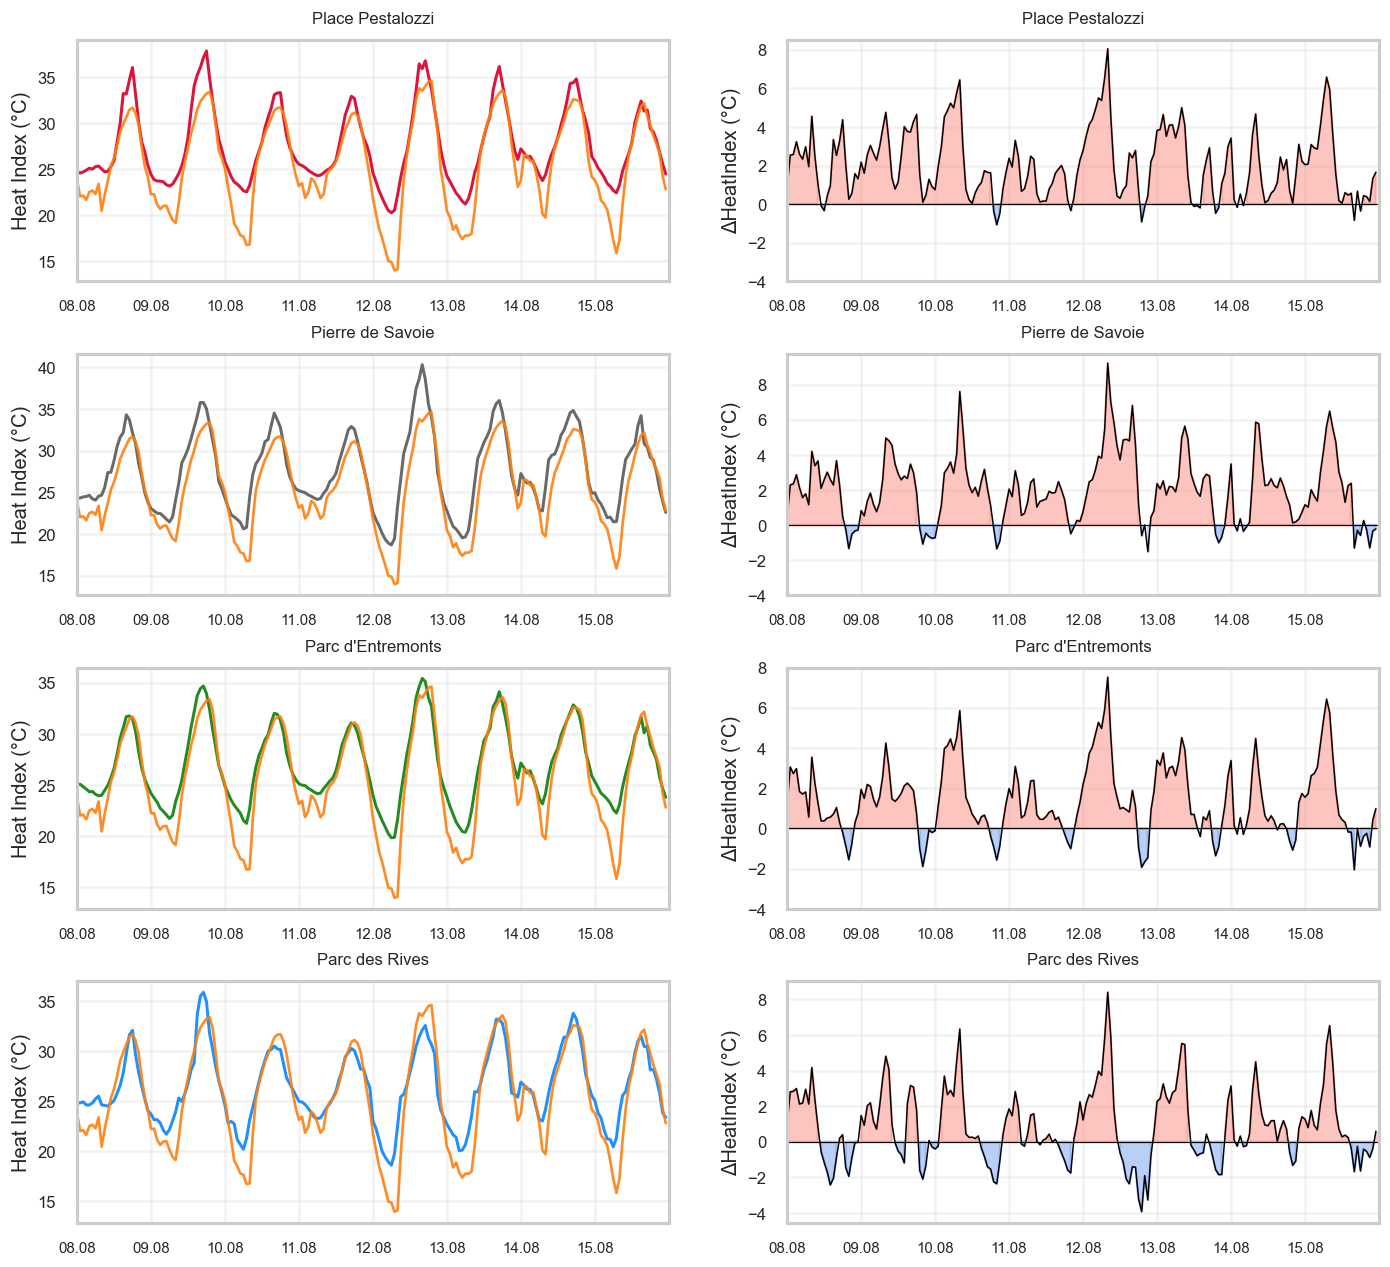

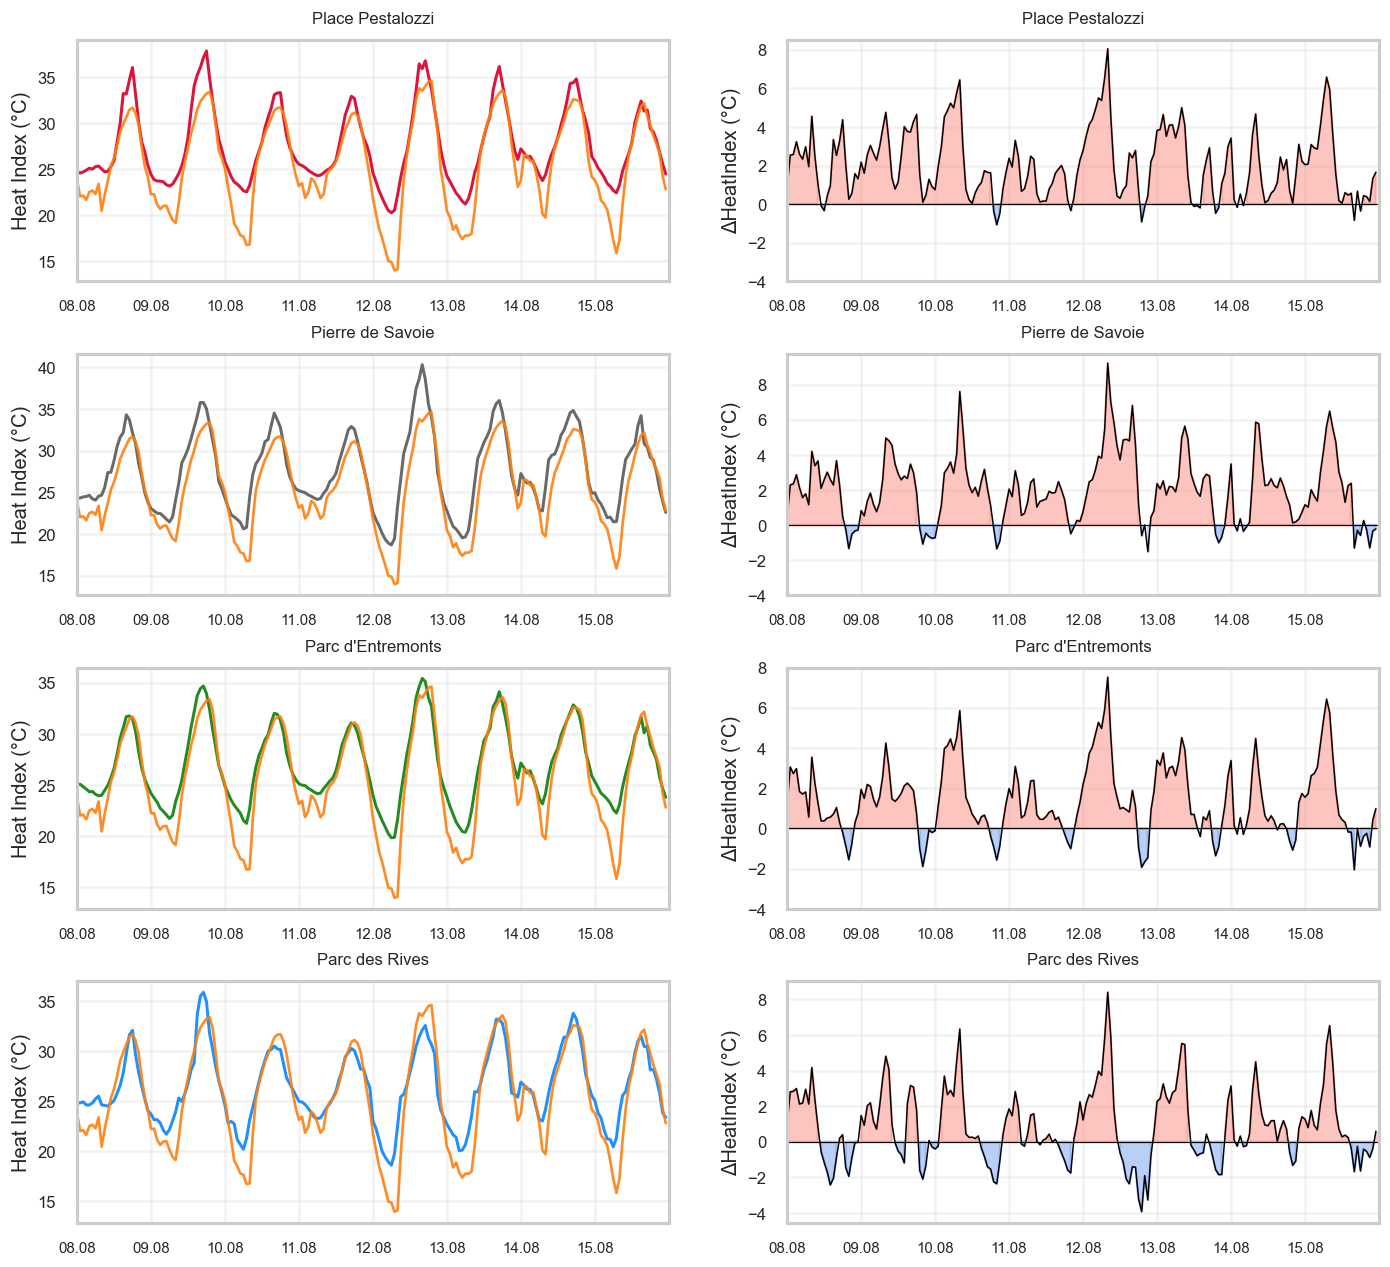

In [371]:
plot_heat_index_8(combined_df,
                  stations=["Place Pestalozzi","Pierre de Savoie","Parc d'Entremonts","Parc des Rives"],
                  meteo_abbr="MAH",
                  start_date="2025-08-08",
                  end_date="2025-08-15")